In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import json
import folium
import branca.colormap as cm
import seaborn as sns

import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import *
from pyspark.sql.functions import *

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

# 1. GDELT analysis

In [2]:
# Load the filtered dataframe
dataframe = spark.read.parquet("../blagojce/data/data_frame.parquet")

In [3]:
# CAMEO codes of all coutries in EEA 
cameo_codes = ['AUT','BEL','BGR','HRV','CYP','CZE','DNK',
             'EST','FIN','FRA','DEU','GRC','HUN', 'ISL', 'IRL','ITA','LVA','LTU',
             'LUX','MLT','NLD','NOR', 'POL','PRT','SVK','SVN','ESP',
             'SWE','CHE','GBR']
# Names of all coutries in EEA
countries = ['Austria','Belgium','Bulgaria','Croatia','Cyprus','Czech Republic','Denmark',
             'Estonia','Finland','France','Germany','Greece','Hungary', 'Iceland', 'Ireland','Italy','Latvia','Lithuania',
             'Luxembourg','Malta','Netherlands','Norway','Poland','Portugal','Slovak Republic','Slovenia','Spain',
             'Sweden','Switzerland','United Kingdom']

In [4]:
# Create a dataframe with the name of the countries and the corresponding CAMEO codes
country_cameo_codes = pd.DataFrame()
country_cameo_codes['Country'] = countries
country_cameo_codes['Cameo_code'] = cameo_codes

In [5]:
country_cameo_codes.head()

Country Cameo_code
0   Austria        AUT
1   Belgium        BEL
2  Bulgaria        BGR
3   Croatia        HRV
4    Cyprus        CYP

## Parties

In [6]:
parties = pd.read_csv("data/country_party_dataset.csv", index_col=0)
positions = pd.read_csv("data/positions_scale.csv")

In [7]:
positions_sorted = ['far-left', 'left-wing to far-left', 'left-wing', 'centre-left to left-wing', 'centre-left', \
                    'centre to centre-left', 'centre', 'syncretic', 'big tent', 'centre to centre-right', \
                    'centre-right', 'centre-right to right-wing', 'right-wing', 'right-wing to far-right', \
                    'far-right']

In [8]:
parties = pd.merge(parties, positions, left_on=["Political_position"], right_on=["Position"])

In [9]:
parties["weighted_seats_last"] = (parties["Seats %_last"]/100)*parties["Scale"]
parties["weighted_seats_previous"] = (parties["Seats %_previous"]/100)*parties["Scale"]

In [10]:
parties = parties.groupby("Country").sum()

In [11]:
parties["difference"] = parties["weighted_seats_last"] - parties["weighted_seats_previous"]

In [12]:
parties = parties.reset_index()

In [13]:
parties_short = parties[['Country','weighted_seats_previous','weighted_seats_last','difference']]

In [14]:
parties_short = parties_short.merge(country_cameo_codes,how='inner',on='Country')

In [15]:
parties_short.head()

Country  weighted_seats_previous  weighted_seats_last  difference  \
0   Austria                 0.956284             1.371585    0.415301   
1   Belgium                 0.873333             0.760000   -0.113333   
2  Bulgaria                 1.029167             0.454167   -0.575000   
3   Croatia                 0.539568             0.532374   -0.007194   
4    Cyprus                -0.892857            -0.375000    0.517857   

  Cameo_code  
0        AUT  
1        BEL  
2        BGR  
3        HRV  
4        CYP

## Events

In [16]:
# CAMEO codes for each event type
event_codes = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20']
# Names of the corresponding event types
event_names = ['MAKE PUBLIC STATEMENT','APPEAL','EXPRESS INTENT TO COOPERATE','CONSULT','ENGAGE IN DIPLOMATIC COOPERATION',\
               'ENGAGE IN MATERIAL COOPERATION','PROVIDE AID','YIELD','INVESTIGATE','DEMAND','DISAPPROVE','REJECT','THREATEN',\
              'PROTEST','EXHIBIT FORCE POSTURE','REDUCE RELATIONS','COERCE','ASSAULT','FIGHT',\
               'USE UNCONVENTIONAL MASS VIOLENCE']

In [17]:
# Create a dataframe with each event type name and CAMEO code
event_codes_names = pd.DataFrame()
event_codes_names['codes'] = event_codes
event_codes_names['names'] = event_names

In [18]:
event_codes_names.head(5)

codes                             names
0    01             MAKE PUBLIC STATEMENT
1    02                            APPEAL
2    03       EXPRESS INTENT TO COOPERATE
3    04                           CONSULT
4    05  ENGAGE IN DIPLOMATIC COOPERATION

Since we extensively extract data from the GDELT dataset in our analysis, we use two functions (**get_country_data** and **create_pandas_dataframe**) to automatize this process and avoid code repetition.

The function **get_country_data** takes 5 arguments:
1. **countries** is a list containing the CAMEO codes of the countries involved in the events
2. **countries** is a list of the years when the events took place
3. **event_type** is a list of the CAMEO codes of the event types we want to examine
4. **internal** specifies whether we examine internal (events within a country), external (events between the given country and other countries) or both (internal and external)
5. **gov** specifies whether we consider only actions performed by Governments

In [19]:
def get_country_data(countries, years, event_type, internal, gov):
    # Internal events
    if internal == 1:
        temp = dataframe.filter(((dataframe['Actor1CountryCode'].isin(countries))\
                                & (dataframe['Actor2CountryCode'] == dataframe['Actor1CountryCode']))\
                                & ((dataframe['EventRootCode'].isin(event_type)) & (dataframe['Year_Date'].isin(years))))
    # External events
    elif internal == 2:
        temp = dataframe.filter(((dataframe['Actor1CountryCode'].isin(countries))\
                                & (dataframe['Actor2CountryCode'] != dataframe['Actor1CountryCode']))\
                                & ((dataframe['EventRootCode'].isin(event_type)) & (dataframe['Year_Date'].isin(years))))
    # Both (internal and external)
    else:
        temp = dataframe.filter((dataframe['Actor1CountryCode'].isin(countries))\
                                & (dataframe['EventRootCode'].isin(event_type)) & (dataframe['Year_Date'].isin(years)))
    
    # Only actions performed by governments
    if gov == 1:
        temp = temp.filter(temp['Actor1Type1Code'] == 'GOV')
    
    return temp

The function **get_country_data** is used to transform Spark dataframes into Pandas dataframes with regards to different parameters per country (number of events, event types, average tone, goldstein scale). It takes two arguments:
1. **events** is the Spark dataframe with the filtered events of interest
2. **parameter** specifies the feature (parameter) we want to examine 

In [20]:
def create_pandas_dataframe(events,parameter): 
    # Number of events per country
    if parameter == 'count':
        temp = events.groupBy('Actor1CountryCode').count()
    # Number of each event type per country
    elif parameter == 'EventRootCode':
        temp = events.groupBy('EventRootCode').count()
    # Average tone per country
    elif parameter == 'AvgTone':
        temp = events.groupBy('Actor1CountryCode').mean('AvgTone')
    # Average Goldstein Scale per country
    elif parameter == 'GoldsteinScale':
        temp = events.groupBy('Actor1CountryCode').mean('GoldsteinScale')
    else:
        print('Wrong arguments')
        return
    
    temp_pd = temp.toPandas()
    return temp_pd

### Average tone and Goldstein Scale

In this part, we examine the differences between right-leaning and left-leaning Governments by analyzing the Average Tone and the average Goldstein Scale of actions performed by each Government. 

First we show as reference the average tone for external and internal events for all EEA countries in the last 3 years. To achieve this, we use a function **get_avg** which takes as parameter a spark dataframe and the parameter we wish to calculate the average.

In [21]:
def get_avg(events,parameter):
    # Group by country
    temp = events.groupBy('Actor1CountryCode').mean(parameter)
    pd = temp.toPandas()
    avg_parameter = 'avg(' + parameter + ')'
    # Return the average over all countries
    return pd[avg_parameter].mean()

In [22]:
# Get all actions (internal and external) performed by EEA Governments in 2015,2016 and 2017 
events_all = get_country_data(cameo_codes, ['2015','2016','2017'], event_codes, 0, 1)

In [23]:
# Internal events of each year
internal_2015 = get_country_data(cameo_codes, ['2015'], event_codes, 1, 1)
internal_2016 = get_country_data(cameo_codes, ['2016'], event_codes, 1, 1)
internal_2017 = get_country_data(cameo_codes, ['2017'], event_codes, 1, 1)

In [24]:
# External events of each year
external_2015 = get_country_data(cameo_codes, ['2015'], event_codes, 2, 1)
external_2016 = get_country_data(cameo_codes, ['2016'], event_codes, 2, 1)
external_2017 = get_country_data(cameo_codes, ['2017'], event_codes, 2, 1)

In [25]:
# Create list with the average tone of each year
average_tone_internal = [get_avg(internal_2015,'AvgTone'),get_avg(internal_2016,'AvgTone'),get_avg(internal_2017,'AvgTone')]
average_tone_external = [get_avg(external_2015,'AvgTone'),get_avg(external_2016,'AvgTone'),get_avg(external_2017,'AvgTone')]

In [26]:
# Create list with the goldstein scale of each year
goldstein_internal = [get_avg(internal_2015,'GoldsteinScale'),get_avg(internal_2016,'GoldsteinScale'),\
                     get_avg(internal_2017,'GoldsteinScale')]
goldstein_external = [get_avg(external_2015,'GoldsteinScale'),get_avg(external_2016,'GoldsteinScale'),\
                     get_avg(external_2017,'GoldsteinScale')]

In [27]:
# Create Pandas dataframe
tone_goldstein_pd = pd.DataFrame()
tone_goldstein_pd['year'] = [2015,2016,2017]
tone_goldstein_pd['avg_tone_internal'] = average_tone_internal
tone_goldstein_pd['avg_tone_external'] = average_tone_external
tone_goldstein_pd['goldstein_internal'] = goldstein_internal
tone_goldstein_pd['goldstein_external'] = goldstein_external

In [28]:
# colors used for our plots
blue = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
red = (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)
blue = '#%02x%02x%02x' %tuple([int(255*x) for x in blue])
red = '#%02x%02x%02x' %tuple([int(255*x) for x in red])

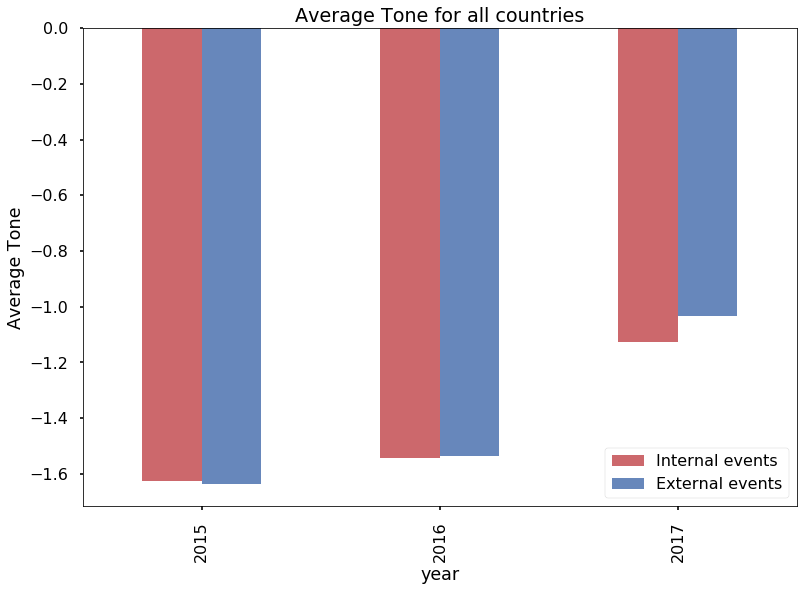

In [30]:
plt.style.use('seaborn-poster')
tone_goldstein_pd.plot(kind='bar',x='year',y=['avg_tone_internal','avg_tone_external'],color=[red, blue], alpha=0.85)
plt.title('Average Tone for all countries')
plt.ylabel('Average Tone')
plt.legend(["Internal events", "External events"])
plt.savefig("Average Tone for all countries.png", bbox_inches="tight", dpi=200)
plt.show()

We can observe that the average tone is negative for every year, with 2015 and 2016 having the lowest average tone, which could be explained by the by the outbreak of the refugee crisis in 2015.
The average tone increases in 2017, which means that there is an improvement in both internal and external relationships in the EEA countries. Furthermore, we can see that the average tone for internal and external events is very similar in 2015 and 2016. However, the average tone for external events is higher in 2017, meaning that Governments have a more positive attitude towards foreign than internal affairs. 

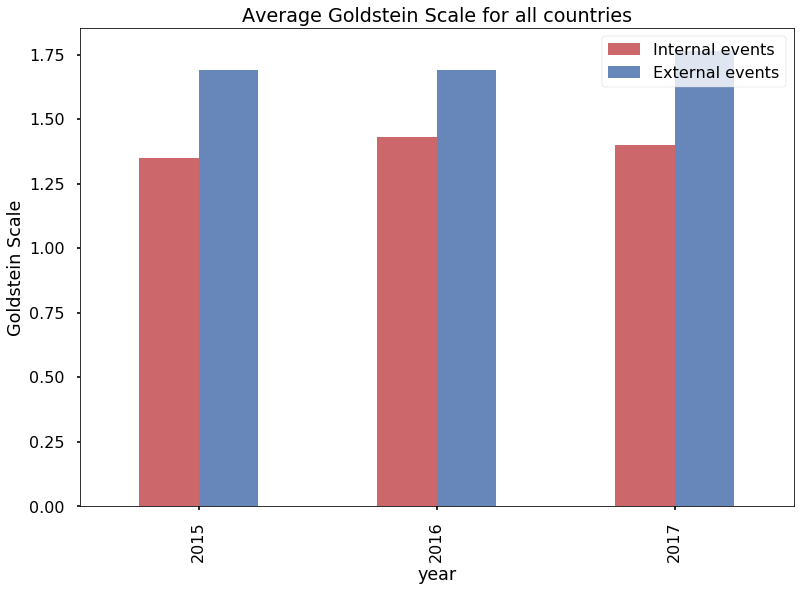

In [31]:
plt.style.use('seaborn-poster')
tone_goldstein_pd.plot(kind='bar',x='year',y=['goldstein_internal','goldstein_external'],color=[red, blue], alpha=0.85)
plt.title('Average Goldstein Scale for all countries')
plt.ylabel('Goldstein Scale')
plt.legend(["Internal events", "External events"])
plt.savefig("Average Goldstein Scale for all countries.png", bbox_inches="tight", dpi=200)
plt.show()

Unlike the average tone, the Goldstein Scale is almost constant, with slight increase for internal events in 2016 and external events in 2017. What is interesting to see is that the Goldstein Scale is higher for external events, meaning that external events have a more positive effect on the political stability for countries than the internal events. 

In [29]:
# Average tone per country
avg_tone = create_pandas_dataframe(events_all,'AvgTone')
# Average Goldstein Scale per country
goldstein = create_pandas_dataframe(events_all,'GoldsteinScale')

In [30]:
# Merge both dataframes with the dataframe containing the election results for each country
avg_tone_parties = avg_tone.merge(parties_short,left_on='Actor1CountryCode',right_on='Cameo_code')
goldstein_parties = goldstein.merge(parties_short,left_on='Actor1CountryCode',right_on='Cameo_code')

In [31]:
# Sort dataframes
avg_tone_sorted = avg_tone_parties.sort_values(by='avg(AvgTone)')
goldstein_sorted = goldstein_parties.sort_values(by='avg(GoldsteinScale)')

In order to observe the connection between the average tone/Goldstein Scale and the ideology of the Government (left/right), we color the bar of each country in the plot with red (right) or blue (left).Furthermore, a higher intensity of the color depicts a bigger difference in the number of seats in the last elections between right/left parties in the given country. To achieve this, we use a linear colormap and a function **fill_colors** that maps the weighted seats of each country to a corresponding color. The function takes as arguments the dataframe used for the plot and the column containing the parameter used for the coloring, which could be the weighted seats in the last or previous election, as well as the difference between the last two elections. The function returns a list of strings (Hex code) of the color for each country.  

In [32]:
color_palette = np.load("data/color_palette_weighted_seats_last.npy").item()

In [33]:
# Colormap used for the plot
colormap_lean = cm.LinearColormap(colors=['blue','white','red'], index=[-1,0,1],vmin=-3,vmax=3)

In [34]:
# New method
def fill_colors(dataframe):
    colors = []
    # Iterate through the dataframe
    for index, row in dataframe.iterrows():
        # Append the color hex code for the given country
        country = row["Country"]
        color = color_palette[country]
        temp = tuple([int(255*x) for x in color])
        colors.append('#%02x%02x%02x' % temp)
    return colors

In [35]:
# Colors depicting the weighted seats from the last elections
colors_tone = fill_colors(avg_tone_sorted)

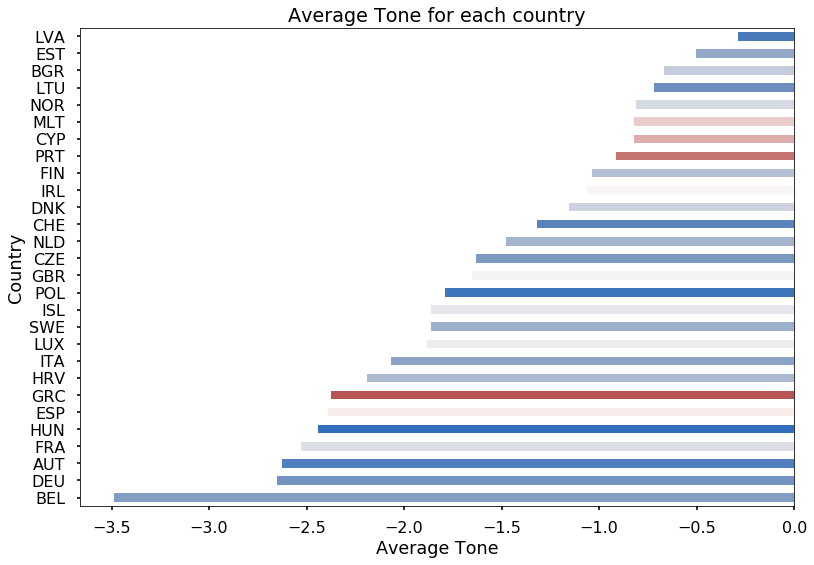

In [39]:
plt.style.use('seaborn-poster')
avg_tone_sorted.plot(kind='barh',x='Actor1CountryCode',y='avg(AvgTone)',color=colors_tone,legend=False)
plt.title('Average Tone for each country')
plt.xlabel('Average Tone')
plt.ylabel('Country')
plt.savefig("Average Tone for each country.png", bbox_inches="tight", dpi=200)
plt.show()

Although it is hard to draw a general conclusion from the plot, we can make a few observations. We can see that right-wing Governments such as Belgium, Austria, Germany and Hungary have the lowest average tone and left-wing Governments such as Portugal, Cyprus, Malta have one of the highest average tones.
The exceptions to this trend are the Baltic Governments which have the best average tone despite being right-wing and Greece which has a fairly low average tone despite having a left-wing Government. 

In [36]:
# Colors depicting the weighted seats from the last elections
colors_goldstein = fill_colors(goldstein_sorted)

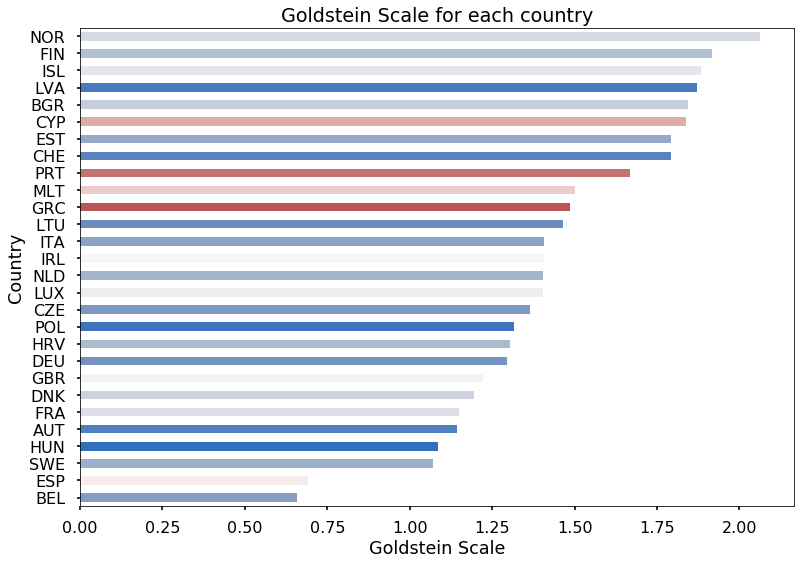

In [43]:
plt.style.use('seaborn-poster')
goldstein_sorted.plot(kind='barh',x='Actor1CountryCode',y='avg(GoldsteinScale)',color=colors_goldstein,legend=False)
plt.title('Goldstein Scale for each country')
plt.xlabel('Goldstein Scale')
plt.ylabel('Country')
plt.show()

We can make a similar observation to the one for the average tone. We can see that the Scandinavian countries have the highest Goldstein scale meaning that they perform actions that have the most positive effect on the political stability of the country. Furthermore, countries with right-wing Governments like Poland, Austria and Belgium have a low Goldstein Scale. In general, we can see that left-wing and centrist Governments tend to have a higher Goldstein Scale.

### Internal vs External events

In the following section, we compare the average tone and average Goldstein scale for internal and external events to see if Governments have a different approach toward internal and foreign affairs.

In [37]:
# Get internal actions performed by EEA Governments in 2015,2016 and 2017 
events_internal = get_country_data(cameo_codes, ['2015','2016','2017'], event_codes, 1, 1)
# Get external actions performed by EEA Governments in 2015,2016 and 2017 
events_external = get_country_data(cameo_codes, ['2015','2016','2017'], event_codes, 2, 1)

In [38]:
# Create the corresponding pandas dataframes
tone_internal = create_pandas_dataframe(events_internal,'AvgTone')
goldstein_internal = create_pandas_dataframe(events_internal,'GoldsteinScale')
tone_external = create_pandas_dataframe(events_external,'AvgTone')
goldstein_external = create_pandas_dataframe(events_external,'GoldsteinScale')

In [39]:
# Merge the average tone of the external and internal actions in a single dataframe
tone_merged = tone_internal.merge(tone_external,on='Actor1CountryCode',suffixes=('_internal','_external'))
# Merge the average Goldstein Scale of the external and internal actions in a single dataframe
goldstein_merged = goldstein_internal.merge(goldstein_external,on='Actor1CountryCode',suffixes=('_internal','_external'))

In [40]:
# Sort dataframes
tone_sorted = tone_merged.sort_values(by='avg(AvgTone)_internal')
goldstein_combined_sorted = goldstein_merged.sort_values(by='avg(GoldsteinScale)_internal')

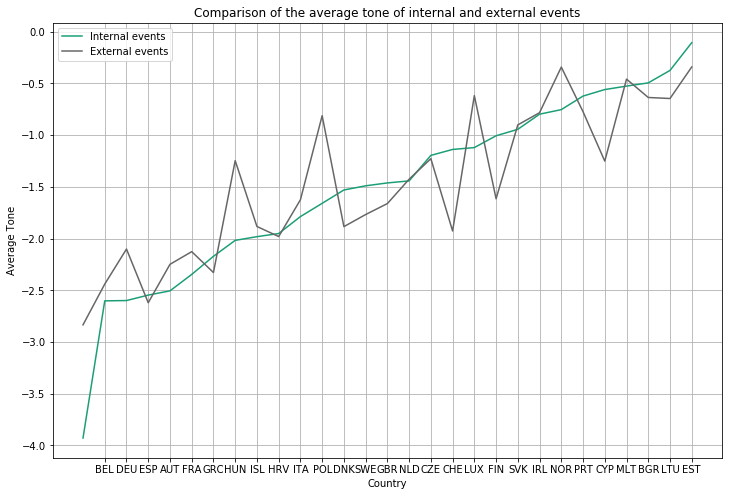

In [41]:
# Line plot of the average tone for external and internal events
plot = tone_sorted.plot(kind='line', colormap='Dark2', x='Actor1CountryCode',y=['avg(AvgTone)_internal','avg(AvgTone)_external']\
                 ,xticks=range(1,len(tone_sorted)),figsize=(12,8),grid=True)
_ = plot.set_xticklabels(tone_sorted.Actor1CountryCode)
plt.title('Comparison of the average tone of internal and external events')
plt.ylabel('Average Tone')
plt.xlabel('Country')
plt.legend(["Internal events", "External events"])
plt.show()

We observe from the plot that the average tone for external events "oscilates" around the values for the average tone for internal events, but the average over all countries for internal and external events is similar. This means that, in terms of the average tone, countries generally have a similar approach towards internal and foreign affairs. However, there are several exceptions where the external tone is higher (Iceland, Denmark, Finland, Spain, Portugal) meaning that the Government of these countries has a more friendly relationship with other countries compared to relationships within the country. There are also countries with the opposite holds (Sweden, Luxembourg, Slovakia, Malta).

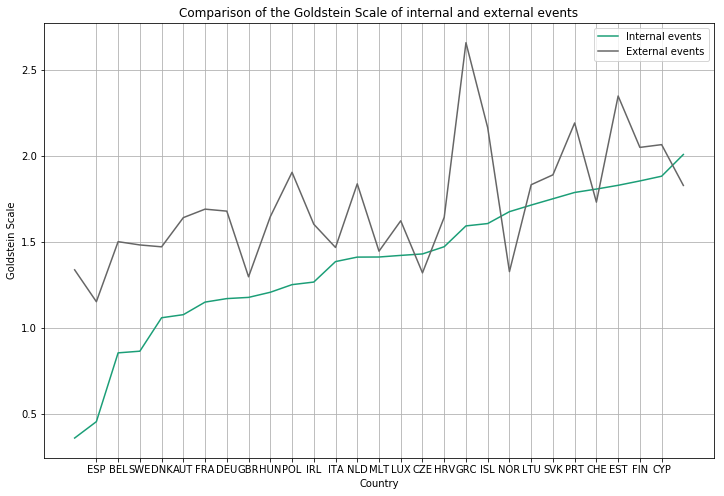

In [42]:
# Line plot of the average Goldstein Scale for external and internal events
plot = goldstein_combined_sorted.plot(kind='line',x='Actor1CountryCode',colormap='Dark2',\
                             y=['avg(GoldsteinScale)_internal','avg(GoldsteinScale)_external'],\
                             xticks=range(1,len(goldstein_sorted)),figsize=(12,8),grid=True)
_ = plot.set_xticklabels(goldstein_combined_sorted.Actor1CountryCode)
plt.title('Comparison of the Goldstein Scale of internal and external events')
plt.ylabel('Goldstein Scale')
plt.xlabel('Country')
plt.legend(["Internal events", "External events"])
plt.show()

Contrary to the Average tone, the average Goldstein Scale for external events is larger than the average Goldstein Scale for internal events. This means that external events have a more positive potential impact stability of the country country, compared to internal events. Except for three cases (Czech Republic, Norway and Switzerland), every other country has a higher Goldstein Scale for external events, with Greece having the largest difference.

### Relationships between Governments

In this part we examine the relationships between the Governments of the EEA countries by observing the average tone of events between pairs of countries.

In [41]:
# Get all external actions between EEA Governments 
events_external_eea = events_external.filter((events_external['Actor2CountryCode'].isin(cameo_codes))\
                                            & (events_external['Actor2Type1Code'] == 'GOV'))
# Number of events for each country pair
relationships = events_external_eea.groupBy(['Actor1CountryCode', 'Actor2CountryCode']).count()
# Average Tone for each country pair
relationships_tone = events_external_eea.groupBy(['Actor1CountryCode', 'Actor2CountryCode']).mean('AvgTone')

In [42]:
# Total number of external events between EEA Governments
events_external_eea.count()

24627

In [43]:
# Convert to Pandas dataframes
relationships_pd = relationships.toPandas()
relationships_tone_pd = relationships_tone.toPandas()

In [44]:
# Exclude pair of countries with less than 50 events
relationships_pd = relationships_pd[relationships_pd['count'] > 50]
relationships_merged = relationships_tone_pd.merge(relationships_pd,how='inner',on=['Actor1CountryCode','Actor2CountryCode'])

In [45]:
# Add the pair label (Country codes) for the plot
relationships_merged['label'] = relationships_merged["Actor1CountryCode"].map(str) + ',' + relationships_merged["Actor2CountryCode"].map(str)

In [46]:
# The 15 pairs with the lowest average tone
worst = relationships_merged.sort_values(by='avg(AvgTone)').head(15)
# The 15 pairs with the highest average tone
best = relationships_merged.sort_values(by='avg(AvgTone)',ascending=False).head(15)

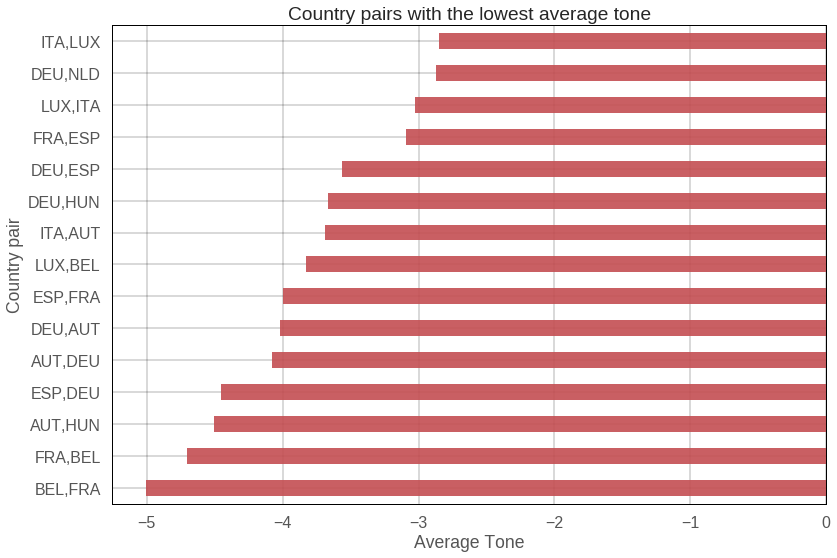

In [75]:
plt.style.use('seaborn-poster')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
ax = worst.plot(kind='barh',x='label',y='avg(AvgTone)',color=red,grid=True,legend=False, alpha=0.90)
ax.set_facecolor("white")
ax.grid(color="black", linewidth=0.3)
plt.title('Country pairs with the lowest average tone')
plt.xlabel('Average Tone')
plt.ylabel('Country pair')
plt.savefig("Country pairs with the lowest average tone.png", bbox_inches="tight", dpi=200)
plt.show()

We can observe from the plot that Belgium and France have the "worst relationship" in terms of the average tone of shared events. The reason why there are two entries in the plot is that the label (BEL,FRA) represents actions performed by Belgium on France and vice versa. What is interesting to see is that almost all of the countries in the plot are neighboring countries. This might explain why the average tone is so low, since neighboring countries in Europe have a lot of unresolved issues and traditional rivalries.

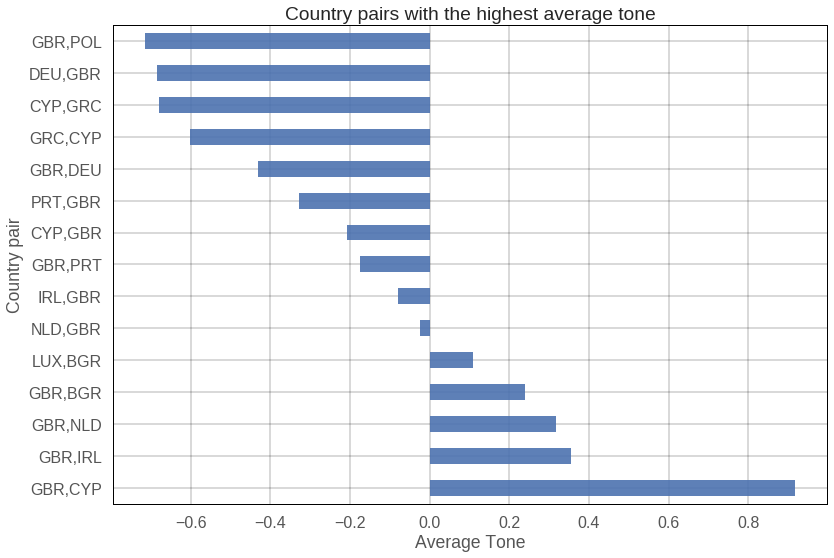

In [78]:
plt.style.use('seaborn-poster')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
ax = best.plot(kind='barh',x='label',y='avg(AvgTone)',color=blue, grid=True,legend=False, alpha=0.9)
ax.set_facecolor("white")
ax.grid(color="black", linewidth=0.3)
plt.title('Country pairs with the highest average tone')
plt.xlabel('Average Tone')
plt.ylabel('Country pair')
plt.savefig("Country pairs with the highest average tone.png", bbox_inches="tight", dpi=200)
plt.show()

We can see from the plot that Great Britain has a very "friendly" approach towards the smaller EEA countries. What is interesting to see is the ralively good relationship between Great Britain and Germany manifested by the higher average tone compared to the other big Western European countries.

### Relationship with the Trump Administration

The biggest indicator of the global rise in popularity of populist right parties was the election of Donald Trump, which has further polarized the political scene in Europe. Therefore, we analyze the relationship between the Governments of the EEA countries and the Trump administration by examining the average tone of events between the Governments of each EEA country and the US Government. Furthermore, we compare the average tone of events before (2015 and 2016) and after (2017) Trump got elected.

In [47]:
# External actions performed by EEA Governments in 2017
events_external_2017 = get_country_data(cameo_codes, ['2017'], event_codes, 2, 1)
# External actions performed by EEA Governments in 2015 and 2016
events_external_2015_2016 = get_country_data(cameo_codes, ['2015','2016'], event_codes, 2, 1)

In [48]:
# External actions performed by EEA Governments on the US Government in 2017
events_trump = events_external_2017.filter((events_external_2017['Actor2CountryCode'] == 'USA') & (events_external_2017['Actor2Type1Code'] == 'GOV'))
# External actions performed by EEA Governments on the US Government in 2015 and 2016
events_pre_trump = events_external_2015_2016.filter((events_external_2015_2016['Actor2CountryCode'] == 'USA') & (events_external_2015_2016['Actor2Type1Code'] == 'GOV'))

In [49]:
# Total number of actions performed by EEA Governments on the US Government in 2017
events_trump.count()

2644

In [50]:
# Total number of actions performed by EEA Governments on the US Government in 2015 and 2016
events_pre_trump.count()

5403

In [51]:
# Calculate the Average Tone
tone_trump = create_pandas_dataframe(events_trump,'AvgTone')
tone_pre_trump = create_pandas_dataframe(events_pre_trump,'AvgTone')

In [52]:
# Merge the dataframes with the events with Trump and before Trump
tone_trump_merged = tone_pre_trump.merge(tone_trump,on='Actor1CountryCode',suffixes=('_pre_trump','_trump'))
# Difference between the average tone with Trump and before Trump
tone_trump_merged['difference'] = tone_trump_merged['avg(AvgTone)_trump'] - tone_trump_merged['avg(AvgTone)_pre_trump']

In [53]:
# Merge the dataframe with the dataframe containing the election results
tone_trump_parties = tone_trump_merged.merge(parties_short,left_on='Actor1CountryCode',right_on='Cameo_code',suffixes=('','_seats'))

In [54]:
tone_trump_parties.head()

Actor1CountryCode  avg(AvgTone)_pre_trump  avg(AvgTone)_trump  difference  \
0               POL               -0.673526           -1.670686   -0.997159   
1               LVA               -0.241259            0.777194    1.018453   
2               FRA               -2.573054           -1.115511    1.457543   
3               ITA               -0.922392           -1.833140   -0.910748   
4               HRV               -2.903879           -1.377125    1.526755   

   Country  weighted_seats_previous  weighted_seats_last  difference_seats  \
0   Poland                 1.649237             2.875817          1.226580   
1   Latvia                 1.090000             1.630000          0.540000   
2   France                -0.467938             0.195841          0.663778   
3    Italy                -0.683955             0.759067          1.443022   
4  Croatia                 0.539568             0.532374         -0.007194   

  Cameo_code  
0        POL  
1        LVA  
2        FRA  
3        ITA  
4        HRV

In [55]:
# Sort by the average tone with Trump
tone_trump_sorted_tone = tone_trump_parties.sort_values(by='avg(AvgTone)_trump')
# Sort by the difference in average tone with Trump and before Trump
tone_trump_sorted_diff = tone_trump_parties.sort_values(by='difference')

In [57]:
# Drop Austia and Luxembourg due to small number of events
tone_trump_sorted_tone = tone_trump_sorted_tone[(tone_trump_sorted_tone['Cameo_code'] != 'AUT')\
                                                & (tone_trump_sorted_tone['Cameo_code'] != 'LUX')]
tone_trump_sorted_diff = tone_trump_sorted_diff[(tone_trump_sorted_diff['Cameo_code'] != 'AUT')\
                                               & (tone_trump_sorted_tone['Cameo_code'] != 'LUX')]

In [58]:
# Colors depicting the weighted seats from the last elections
colors_trump = fill_colors(tone_trump_sorted_tone)

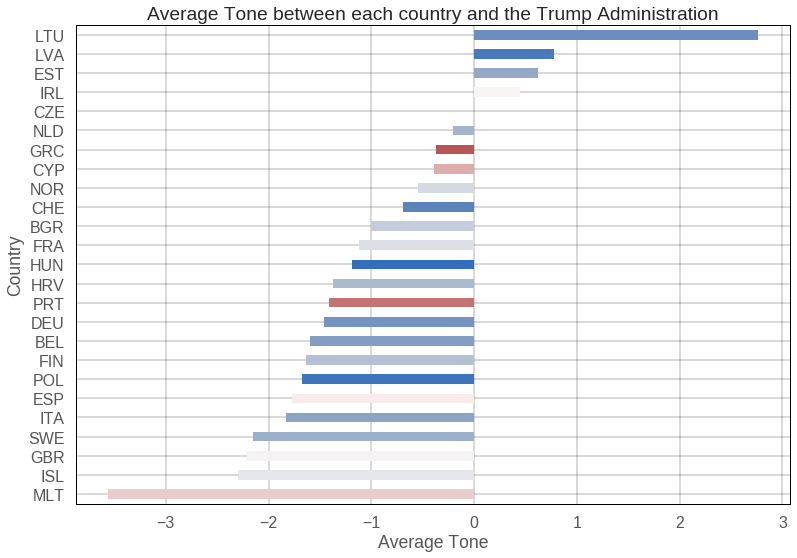

In [92]:
# Plot the average tone of each country with the Trump Administration
plt.style.use('seaborn-poster')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
ax = tone_trump_sorted_tone.plot(kind='barh',x='Actor1CountryCode',y='avg(AvgTone)_trump',color=colors_trump,\
                           grid=True,legend=False)
ax.set_facecolor("white")
ax.grid(color="black", linewidth=0.3)
plt.title('Average Tone between each country and the Trump Administration')
plt.xlabel('Average Tone')
plt.ylabel('Country')
plt.show()

For this plot, we use the same coloring scheme depicting the lean of each Government which is explained above. We can see that the Governments of the Baltic countries have the highest average tone, which is not surprising considering the fact that all these Governments are composed of right leaning parties. We can see that balanced countries with Governments composed of centrist parties (Malta, Iceland and Great Britain) have the lowest average tone (worst relationship) with the Trump Administration. It is evident that only right-leaning Governments have relatively good relationships with the Trump Administration with the only exceptions being Greece and Cyprus. However, we cannot jump to the conclusion that right leaning Governments have good relationships with the Trump beacuase the Governments of Poland, Italy, Sweden, Belgium, although right leaning, have a relatively low average tone. 

In [64]:
# Colorscale used for the plot
colorscale = cm.LinearColormap(colors=[red,'ghostwhite',blue], vmin=-2.6, vmax=2.6)

In [66]:
# Read the Geo JSON file
EU_geo_path = "data/europe.geojson"
geo_json_data = json.load(open(EU_geo_path))

import folium
import branca.colormap as cm

# Function for coloring the countires
def style_function(feature):
    if feature not in list(tone_trump_sorted_tone["Country"]):
        return colorscale(0)
    value = tone_trump_sorted_tone[tone_trump_sorted_tone["Country"] == feature]["avg(AvgTone)_trump"].values[0]
    return colorscale(value)

# Create map
m = folium.Map(
    location=[54, 12],
    tiles='cartodbpositron',
    zoom_start=4
)

# Add Geo JSON data to the map with custom colors
folium.GeoJson(geo_json_data,
    name='geojson',
    style_function=lambda feature: {
        'fillOpacity': 0.9,
        'fillColor': style_function(feature['properties']['NAME']),
        'color' : 'black',
        'weight' : 1
        }
    ).add_to(m)

m.save("Trump_map_avg_tone.html")
m

In [67]:
# Colors depicting the weighted seats from the last elections
colors_trump_diff = fill_colors(tone_trump_sorted_diff)

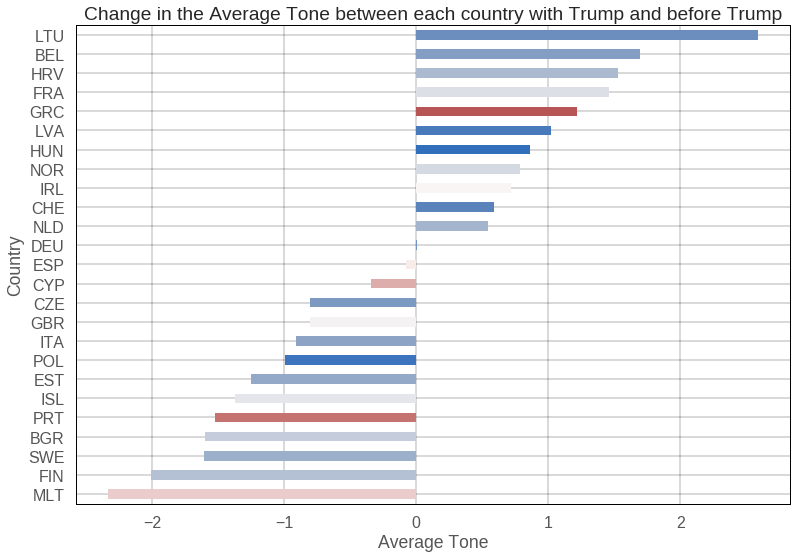

In [93]:
# Plot the change in average tone of each country before and with Trump
plt.style.use('seaborn-poster')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
ax = tone_trump_sorted_diff.plot(kind='barh',x='Actor1CountryCode',y='difference',color=colors_trump_diff,\
                    grid=True,legend=False)
ax.set_facecolor("white")
ax.grid(color="black", linewidth=0.3)
plt.title('Change in the Average Tone between each country with Trump and before Trump')
plt.xlabel('Average Tone')
plt.ylabel('Country')
plt.savefig("Change in the Average Tone between each country with Trump and before Trump.png", bbox_inches="tight", dpi=200)
plt.show()

This graph shows the difference in the average tone of each EEA country with the US Government before(2015 and 2016) and after(2017) Trump got elected. A positive change in the average tone means that the relationship between the country and the US Government has improved. We can that centrist Governments have the biggest negative change, with Estonia, Poland, Italy and the Czech Republic being exceptions. On the contrary, we can see that only right-leaning Governments have improved the relationship with the US Government, with exception of Ireland and Greece. However, the case of Greece is different due to the complicated and polarized political landcape in the country and needs a more thorough analysis.

It is important to state that we cannot jump to conclusions with these results because the overall average tone in the year 2015 is a lot lower than 2017, mostly due to the outbreak of the refugee crisis in 2015. Therefore, an improvement in the average tone does not necessarily mean that the country has an improved relationship with the Trump Administration. 

Taking everything into account, we can see from the plots above that right-leaning Governments tend to be more "friendly" towards the Trump Administration compared to centrist and left-leaning Governments. 

In order to better visualize the relationship of the countries with the Trump Administration, we show a map where the countries are colored depending on the average tone between their Government and the Trump Administration.

In [68]:
# Colorscale used for the plot
colorscale = cm.LinearColormap(colors=[red,'ghostwhite',blue], vmin=-2.6, vmax=2.6)

In [69]:
# Read the Geo JSON file
EU_geo_path = "data/europe.geojson"
geo_json_data = json.load(open(EU_geo_path))

import folium
import branca.colormap as cm

# Function for coloring the countires
def style_function(feature):
    if feature not in list(tone_trump_sorted_diff["Country"]):
        return colorscale(0)
    value = tone_trump_sorted_diff[tone_trump_sorted_diff["Country"] == feature]["difference"].values[0]
    return colorscale(value)

# Create map
m = folium.Map(
    location=[54, 12],
    tiles='cartodbpositron',
    zoom_start=4
)

# Add Geo JSON data to the map with custom colors
folium.GeoJson(geo_json_data,
    name='geojson',
    style_function=lambda feature: {
        'fillOpacity': 0.9,
        'fillColor': style_function(feature['properties']['NAME']),
        'color' : 'black',
        'weight' : 1
        }
    ).add_to(m)

m.save("Trump_map_difference.html")
m

### Relationship between the Government and the opposition/criminals

In this part, we want to analyze the relationship between each Government and different entities in the corresponding country, such as the political opposition, various religious groups, as well as criminals. However, due to the fact that most of the entries in the GDELT dataset have the value 'None' in the feature **Actor2Type1Code** which is used to filter entities such as: opposition,religious group or criminal. Therefore the number of events is insufficient to conduct a relevant analysis.

In [61]:
# Actions performed by the Government on the political opposition
events_internal_opposition = events_internal.filter(events_internal['Actor2Type1Code'] == 'OPP')
# Actions performed by the Government on criminals
events_internal_criminals = events_internal.filter(events_internal['Actor2Type1Code'] == 'CRM')

In [62]:
# Total number of actions performed by the Government on the political opposition
events_internal_opposition.count()

146

In [63]:
# Total number of actions performed by the Government on criminals
events_internal_criminals.count()

74

# Event types

In order to analyze the behavior of right-leaning Governments, we analyze the types of actions (events) they have performed and compare it actions performed by centrist Governments. In order to do so, we split the countries into two groups:
1. **countries_right** contains countries where the value: "weighted seats" from the last elections are larger than 1 (right-leaning Governments)
2. **countries_center** contains countries where the value: "weighted seats" from the last elections are between -0.5 and 0.5 (centrist Governments)

In [64]:
# List of CAMEO codes of countries with right-leaning Governments
countries_right = list(parties_short[parties_short['weighted_seats_last'] > 1].Cameo_code.values)
# List of CAMEO codes of countries with centrist Governments
countries_center = list(parties_short[(parties_short['weighted_seats_last'] < 0.5)\
                                     &(parties_short['weighted_seats_last'] > -0.5)].Cameo_code.values)

In [65]:
# Actions (internal and external) performed by all EEA Governments
events_all = get_country_data(cameo_codes, ['2015','2016','2017'], event_codes, 0, 1)
# Actions (internal and external) performed by right-leaning EEA Governments
events_right = get_country_data(countries_right, ['2015','2016','2017'], event_codes, 0, 1)
# Actions (internal and external) performed by centrist EEA Governments
events_center = get_country_data(countries_center, ['2015','2016','2017'], event_codes, 0, 1)

In [66]:
get_avg(events_right,'AvgTone')

-1.6901145556329704

In [67]:
get_avg(events_center,'AvgTone')

-1.3909699416222692

The events are differentiated by the CAMEO event root code stored in the feature: "EventRootCode". We filter the types of events based on their event root code and compute the number of each event type for every country. Since every country has a different number of events, we calculate the weighted count of the event types with regard to the total number of events for that country.

In [68]:
# Create Pandas dataframes
event_types = create_pandas_dataframe(events_all,'EventRootCode')
event_types_right = create_pandas_dataframe(events_right,'EventRootCode')
event_types_center = create_pandas_dataframe(events_center,'EventRootCode')

In [69]:
# Calculate the weighted count for each event type
event_types['weighted_count'] = event_types['count']/event_types['count'].sum()
event_types_right['weighted_count'] = event_types_right['count']/event_types_right['count'].sum()
event_types_center['weighted_count'] = event_types_center['count']/event_types_center['count'].sum()

In [70]:
# Merge the three dataframes into one
events_merged = event_types.merge(event_types_right,on='EventRootCode',suffixes=('','_right'))
events_merged = events_merged.merge(event_types_center,on='EventRootCode',suffixes=('','_center'))

In [71]:
# Merge the dataframe with the dataframe containing the event CAMEO codes and names
events_merged = event_codes_names.merge(events_merged,how='inner',left_on='codes',right_on='EventRootCode')

In [72]:
events_merged.head()

codes                             names EventRootCode   count  \
0    01             MAKE PUBLIC STATEMENT            01  204316   
1    02                            APPEAL            02  101860   
2    03       EXPRESS INTENT TO COOPERATE            03  111874   
3    04                           CONSULT            04  321368   
4    05  ENGAGE IN DIPLOMATIC COOPERATION            05  108100   

   weighted_count  count_right  weighted_count_right  count_center  \
0        0.173485        42140              0.170627        123761   
1        0.086490        20906              0.084649         63080   
2        0.094992        23314              0.094399         68670   
3        0.272874        73447              0.297390        184336   
4        0.091788        21688              0.087816         67495   

   weighted_count_center  
0               0.173128  
1               0.088242  
2               0.096062  
3               0.257866  
4               0.094418

First, in order to observe the proportion of event types in the dataset, we plot the weighted count of all event types for all countries. The event types are colored based on whether they are positive and negative. We can see that the dominant events are the ones regarding public statements and meetings(CONSULT). 

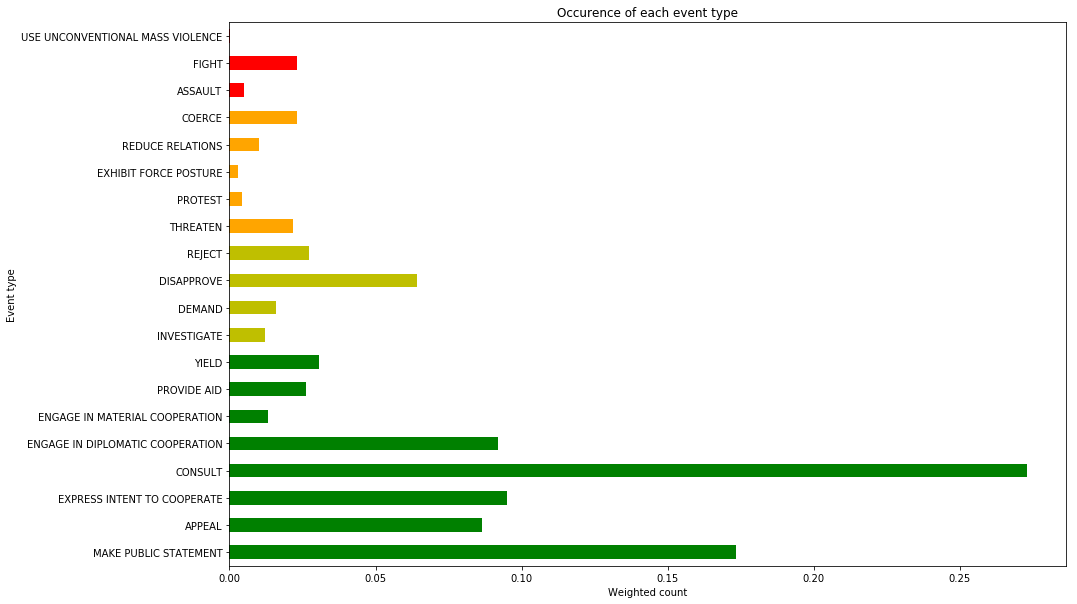

In [74]:
colors = ['g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'y', 'y', 'y', 'y', 'orange', 'orange', 'orange', 'orange', 'orange', 'r', 'r', 'r']
ax = events_merged.plot(kind='barh',color = colors, x='names', y='weighted_count',figsize = (15,10),\
                   legend=False)

plt.title('Occurence of each event type')
plt.xlabel('Weighted count')
plt.ylabel('Event type')
plt.savefig("Occurence of each event type.png", bbox_inches="tight", dpi=200)
plt.show()

Since our idea is to compare different Governments, we only consider event types which are relevant to our analysis where we can observe meaningful characteristics of the two groups of Governments.

In [75]:
# List of relevant event types
relevant_types = ['EXPRESS INTENT TO COOPERATE','ENGAGE IN DIPLOMATIC COOPERATION','ENGAGE IN MATERIAL COOPERATION',\
                  'PROVIDE AID','DEMAND','REJECT','THREATEN','PROTEST',\
                  'EXHIBIT FORCE POSTURE','REDUCE RELATIONS','COERCE','ASSAULT','FIGHT']

In [76]:
# Keep only relevant events
relevant_events = events_merged[events_merged['names'].isin(relevant_types)]

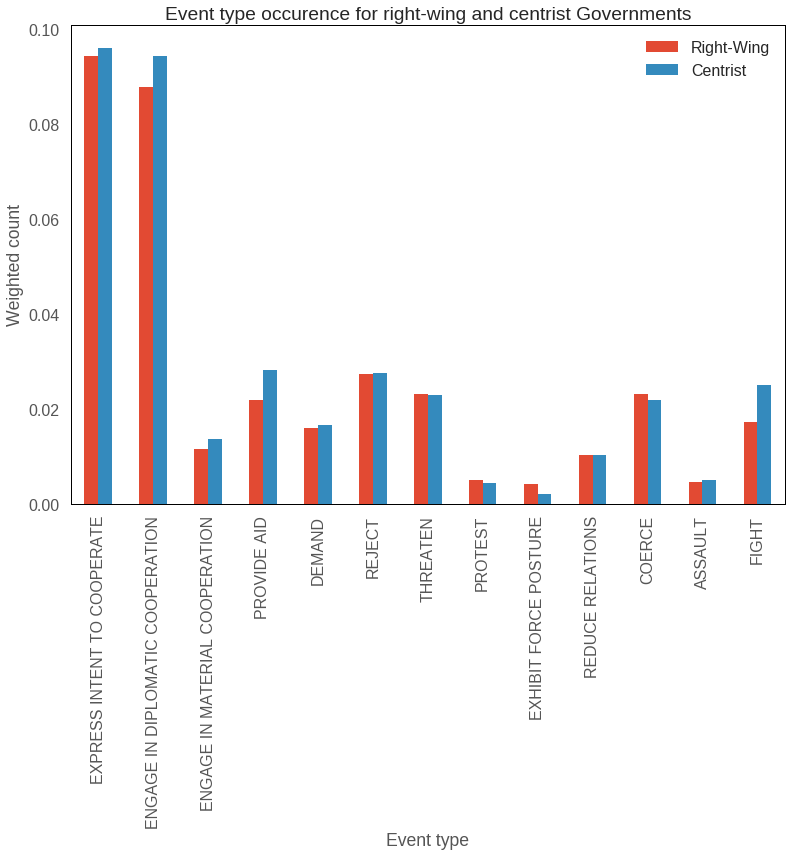

In [114]:
plt.style.use('seaborn-poster')
ax = relevant_events.plot(kind='bar', x='names', y=['weighted_count_right','weighted_count_center'])
ax.set_facecolor("white")
plt.title('Event type occurence for right-wing and centrist Governments')
plt.ylabel('Weighted count')
plt.xlabel('Event type')
plt.legend(["Right-Wing", "Centrist"])
plt.savefig("Event type occurence for right-wing and centrist Governments.png", bbox_inches="tight", dpi=200)
plt.show()

We can see a couple of differences between the two groups. The first three event types show that centrist Governments are more open to cooperation, both diplomatic and material. Furthermore, centrist Governments are more willing to provide aid to internal and external entities. We can conclude that, in terms of cooperation and providing aid, right-leaning Governments are much more closed and reserved.

The second difference is the type: Exhibit force posture, which consists of events like:'Demonstrate military or police power', 'Increase police alert status', 'Mobilize or increase police power'. We can see that the weighted count of this event type for right-leaning Governments is twice as much as centrist Governments, meaning that right-leaning Governments have a higher tendency to exhibit power and use of police and armed forces. 

The third difference is with regard to the event type:Fight which refers to the use of conventional military force. Centrist Governments have a higher weighted count which could be explained by the fact that large centrist-governed countries like Great Britain and France are more involved in external military operations.

### Right vs rest (internal)

In the following part, we observe the difference in occurence of event types in internal and external interactions. In order to do so, we apply the same approach from the previous part for two separate groups of events: internal and external.

In [77]:
# Filter only internal events
events_all_internal = get_country_data(cameo_codes, ['2015','2016','2017'], event_codes, 1, 1)
events_right_internal = get_country_data(countries_right, ['2015','2016','2017'], event_codes, 1, 1)
events_center_internal = get_country_data(countries_center, ['2015','2016','2017'], event_codes, 1, 1)

# Filter only external events
events_all_external = get_country_data(cameo_codes, ['2015','2016','2017'], event_codes, 2, 1)
events_right_external = get_country_data(countries_right, ['2015','2016','2017'], event_codes, 2, 1)
events_center_external = get_country_data(countries_center, ['2015','2016','2017'], event_codes, 2, 1)

In [78]:
# Create dataframes
event_types_internal = create_pandas_dataframe(events_all_internal,'EventRootCode')
event_types_right_internal = create_pandas_dataframe(events_right_internal,'EventRootCode')
event_types_center_internal = create_pandas_dataframe(events_center_internal,'EventRootCode')

event_types_external = create_pandas_dataframe(events_all_external,'EventRootCode')
event_types_right_external = create_pandas_dataframe(events_right_external,'EventRootCode')
event_types_center_external = create_pandas_dataframe(events_center_external,'EventRootCode')

In [79]:
# Calculate the weighted count
event_types_internal['weighted_count'] = event_types_internal['count']/event_types_internal['count'].sum()
event_types_right_internal['weighted_count'] = event_types_right_internal['count']/event_types_right_internal['count'].sum()
event_types_center_internal['weighted_count'] = event_types_center_internal['count']/event_types_center_internal['count'].sum()

event_types_external['weighted_count'] = event_types_external['count']/event_types_external['count'].sum()
event_types_right_external['weighted_count'] = event_types_right_external['count']/event_types_right_external['count'].sum()
event_types_center_external['weighted_count'] = event_types_center_external['count']/event_types_center_external['count'].sum()

In [80]:
# Merge the internal events into one dataframe
events_merged_internal = event_types_internal.merge(event_types_right_internal,on='EventRootCode',\
                                                    suffixes=('','_internal_right'))
events_merged_internal = events_merged_internal.merge(event_types_center_internal,on='EventRootCode',\
                                                      suffixes=('','_internal_center'))

# Merge the external events into one dataframe
events_merged_external = event_types_external.merge(event_types_right_external,on='EventRootCode',\
                                                    suffixes=('','_external_right'))
events_merged_external = events_merged_external.merge(event_types_center_external,on='EventRootCode',\
                                                      suffixes=('','_external_center'))

# Merge both internal and external events into one dataframe
events_merged_all = events_merged_internal.merge(events_merged_external,on='EventRootCode')

In [81]:
# Merge the dataframe with the dataframe containing the event CAMEO codes and names
events_merged_all = event_codes_names.merge(events_merged_all,how='inner',left_on='codes',right_on='EventRootCode')

In [82]:
# Keep only relevant events
relevant_events_all = events_merged_all[events_merged_all['names'].isin(relevant_types)]

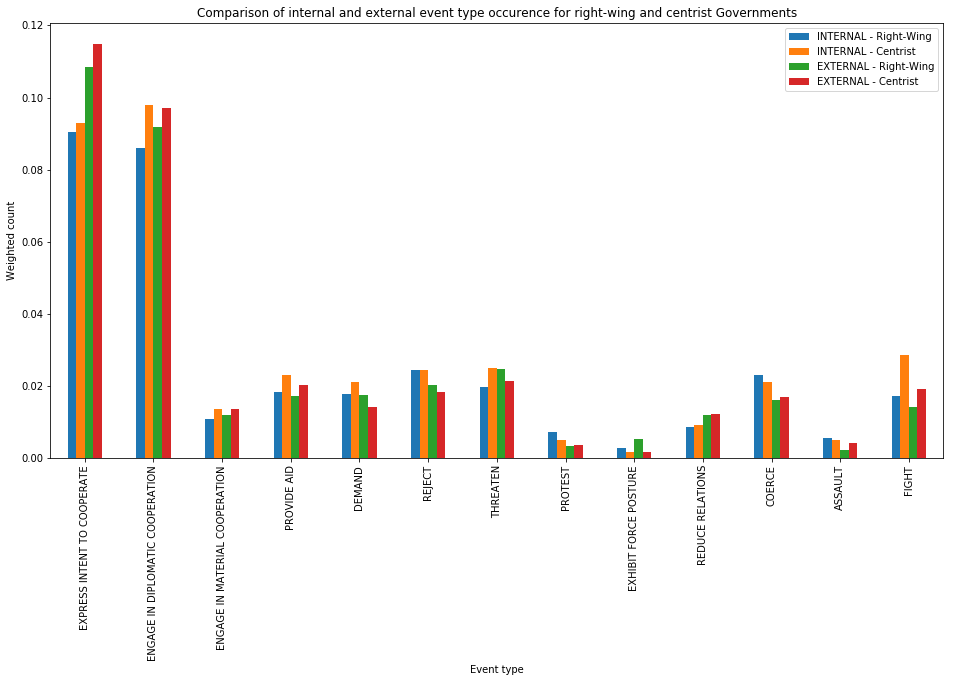

In [84]:
relevant_events_all.plot(kind='bar', figsize = (16,8), x='names',\
                        y=['weighted_count_internal_right','weighted_count_internal_center',\
                           'weighted_count_external_right','weighted_count_external_center'])

plt.title('Comparison of internal and external event type occurence for right-wing and centrist Governments')
plt.ylabel('Weighted count')
plt.xlabel('Event type')
plt.legend(["INTERNAL - Right-Wing", "INTERNAL - Centrist","EXTERNAL - Right-Wing", "EXTERNAL - Centrist"])
plt.savefig("Comparison of internal and external event type occurence for right-wing and centrist Governments.png", bbox_inches="tight", dpi=200)
plt.show()

We can see from the plot that there are a lot of differences in the occurences of internal and external events.

First, we can see that there are a lot more external events of the type: 'Express intent to cooperate', but this is due to the fact that this event type contains events concerning diplomatic relations between countries, similarly to the event type: Engage in diplomatic cooperation.

Second, there is big difference in the event type: 'Demand' for centrist Governments. The reasonning behind this could be that centrist governments are less agressive when it comes to foreign affairs compared to right-wing Governments. This can also be seen from the event type: 'Disapprove' where the difference is much smaller for external events.Furthermore, we can see that the difference in the event type: 'Exhibit force posture' is even bigger for external events which further confirms our observation. The biggest indicator of our observation is the event type: 'Threaten'. We can see that for internal events centrist Governments have a higher weighted count of this type compared to right-wing Governments, but that ratio flips for external events. This means that centrist Governments are more agressive in terms of internal affairs, whereas right-wing Governments are more agressive in terms of foreign issues.

# 2. World indicators analysis

In order to analyze the causes and effects of the rise of populism we will use some of the indicators of the <a href="https://data.worldbank.org/indicator/">World Development Indicators</a> dataset. Specifically, we are currently working with <a href="https://data.worldbank.org/indicator/SM.POP.REFG?fbclid=IwAR3zh3W9eXYD8s09Th_CwKK4Uh-TtmTBOEpPOuJh-RYh3tfVyMEWbXfe_Zo">Refugee population by country or territory of asylum</a>. However, we might use some additional indicators for the next milestones. Because these indicators have identical format, we are only showing the statistics and preprocessing steps for the number of refugees in order to reduce repetition of code. We are additionally using the the <a href="https://datacatalog.worldbank.org/political-stability-and-absence-violenceterrorism-estimate">Political Stability And Absence Of Violence/Terrorism: Estimate</a> dataset. Let us first present the format and basic statistics of these two datasets.

In [1]:
%load_ext autoreload
%autoreload 2

from processing_indicators import read_eveything, plot_everything
import warnings
warnings.filterwarnings('ignore')

In [29]:
# load datasets
stab = pd.read_csv("additional_data/political_stability/political_stability.csv", header=2, sep=',')
refugees = pd.read_csv("additional_data/refugees/refugee_population.csv", header=2, sep=',')

First, we observe the number of countries and the time range covered by the two datasets. 

In [30]:
stab['Country Name'].count()

214

In [31]:
stab.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1996', '1998', '2000', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', 'Unnamed: 23'],
      dtype='object')

In [32]:
refugees['Country Name'].count()

264

In [33]:
refugees.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', 'Unnamed: 62'],
      dtype='object')

We can see that the datasets cover different number of countries and different periods. However, we are only interested in the countries from EU/EEA, and the period between 2007 and today. For this reason, we extract only the countries and years of interest from both datasets.

In [34]:
# countries and features of interest
countries = ['Austria','Belgium','Bulgaria','Croatia','Cyprus','Czech Republic','Denmark',
             'Estonia','Finland','France','Germany','Greece','Hungary','Ireland','Italy','Latvia','Lithuania',
             'Luxembourg','Malta','Netherlands','Poland','Portugal','Romania','Slovak Republic','Slovenia','Spain',
             'Sweden','United Kingdom','Norway','Iceland','Switzerland']
columns = ['Country Name','Country Code','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017']

In [35]:
# extract only countries of interest
stab = stab.loc[stab['Country Name'].isin(countries)]
refugees = refugees.loc[refugees['Country Name'].isin(countries)]

# reset index
stab.reset_index(inplace=True)
refugees.reset_index(inplace=True)

# extract only features of interest
stab = stab[columns]
refugees = refugees[columns]

In [36]:
# number of countries
stab['Country Name'].count()

31

In [37]:
# number of countries
refugees['Country Name'].count()

31

In [38]:
stab.columns

Index(['Country Name', 'Country Code', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')

In [39]:
refugees.columns

Index(['Country Name', 'Country Code', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')

After this preprocessing steps, we can see that the datasets are in a compatible format. In other words, they contain information for the same countries and same years. This will help us in our future analysis. If we are to use any additional indicators from World Bank, the same preprocessing steps can be applied to the indicator of interest in order to convert it to this desired format.

In the following section we explore the correlation between World Bank indicators and the election results. For each indicator, we calculate the difference in the value of the indicator in the year of the first and second. For example, a negative value of the GDP indicates that the GDP was higher in the year when the first election took place than in the year when the second election took place. We compare this difference in value of each indicator with two aspects from the election dataset:

1. <b>Weighted difference in the seats</b> - in this case we test whether there is a correlation between the change in the political position of a Parliament weighted by the percent of seats and the change in the value of the indicator. A negative correlation between GDP and the difference in seats might indicate that the decline in GDP results in shift to the right, which might give us an idea of which factors contribute the most towards shift in the percentage of seats. In this case, we plot the difference in the indicator on the x axis and the shift in political position on the y axis. This is to test whether the difference in the indicator causes a change in political position. 

2. <b>Weighted Seats in the previous election</b> - in this case we are considering whether there is a correlation between the change in the indicator value and the political position of the Parliament after the first election. In this way we can investigate whether right-leaning parliaments perform better or worse concerning different indicators. For example, a negative correlation between the political position of the Parliament and the difference in the value of the indicator might indicate that policies from right-leaning parliaments might cause a decrease in the GDP of a country. 

Under each plot, we present the Spearman coefficient of the relationship between the two variable. We chose Spearman coefficient because it is robust to outliers. We provide brief discussion of the results here, and we have a more detailed analysis of the most meaningful relationships in the final data story.

# Economic Indicators


We start of by observing the correlation with different economic indicators.

### Exports of goods and services (annual % growth)

We see no meaningful relationship here, so we did not put this indicator in the final story.

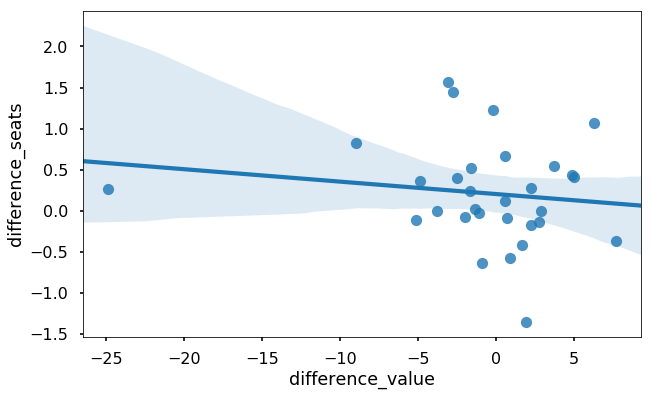

                  difference_value  difference_seats
difference_value          1.000000         -0.187987
difference_seats         -0.187987          1.000000

Data for 30 countires


In [3]:
elections_indicator, parties = read_eveything("additional_data/economic_indicators/export_growth.csv")
plot_everything(elections_indicator, parties, 'difference_value', 'difference_seats')

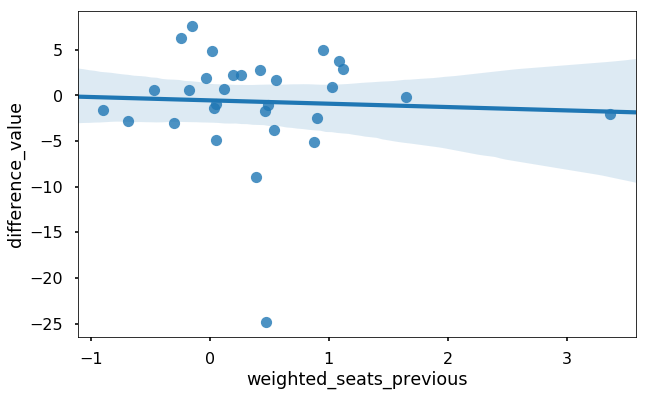

                         weighted_seats_previous  difference_value
weighted_seats_previous                 1.000000         -0.009566
difference_value                       -0.009566          1.000000

Data for 30 countires


In [4]:
plot_everything(elections_indicator, parties, 'weighted_seats_previous', 'difference_value')

### Exports of goods and services (% of GDP)

We see a slight negative correlation between the political position after the first election and the change in the indicator. One possible explanation of this is that right-leaning parties lead more closed politics which results in decrease in the number of exports. We discuss this in the final story.

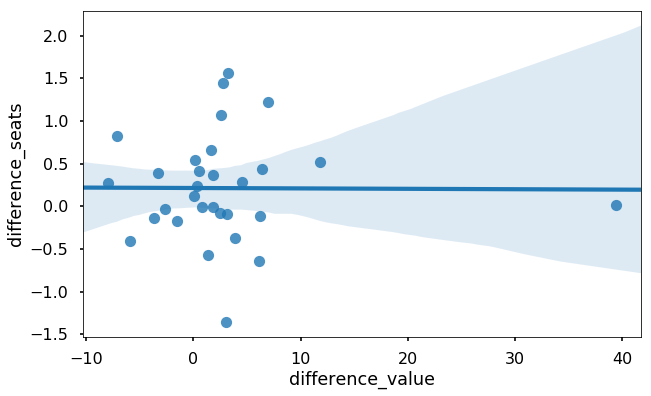

                  difference_value  difference_seats
difference_value          1.000000          0.095439
difference_seats          0.095439          1.000000

Data for 30 countires


In [5]:
elections_indicator, parties = read_eveything("additional_data/economic_indicators/export_percent_of_gdp.csv")
plot_everything(elections_indicator, parties, 'difference_value', 'difference_seats')

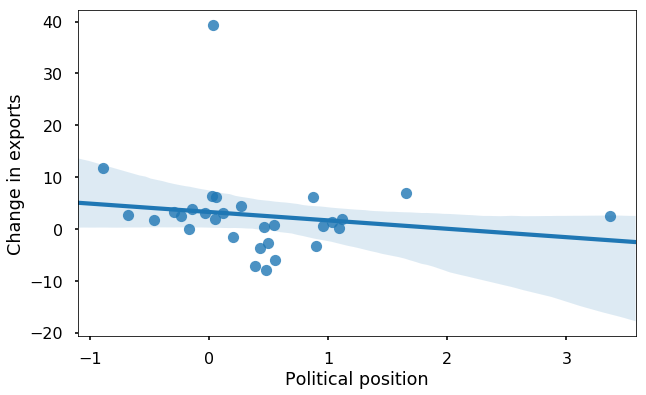

                         weighted_seats_previous  difference_value
weighted_seats_previous                 1.000000         -0.333037
difference_value                       -0.333037          1.000000

Data for 30 countires


In [6]:
params = {}
params["title"] = ""
params["x_label"] = "Political position"
params["y_label"] = "Change in exports"
params["save_2"] = "exports_goods_services.png"
plot_everything(elections_indicator, parties, 'weighted_seats_previous', 'difference_value', params=params)

### Foreign direct investment, net inflows (% of GDP)

Here, we see slight positive correlation in the first plot indicating that increase in foreign investment inflow leads to shift to the right. In the second plot, we see a slight negative correlation indicating that right-leaning policies may cause decrease in foreign investment inflow.

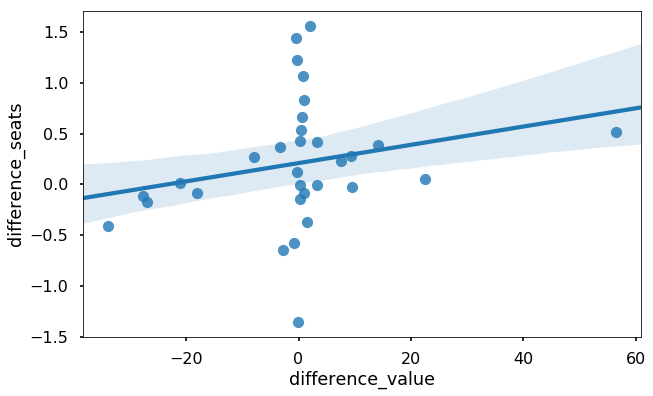

                  difference_value  difference_seats
difference_value          1.000000          0.341532
difference_seats          0.341532          1.000000

Data for 31 countires


In [7]:
elections_indicator, parties = read_eveything("additional_data/economic_indicators/foreign_direct_invesment_in.csv")
plot_everything(elections_indicator, parties, 'difference_value', 'difference_seats')

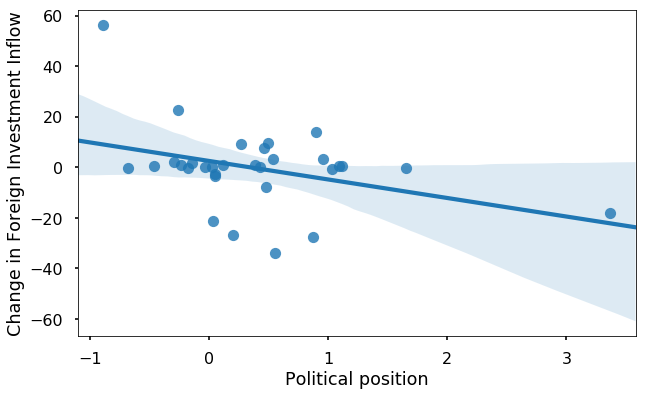

                         weighted_seats_previous  difference_value
weighted_seats_previous                 1.000000         -0.202419
difference_value                       -0.202419          1.000000

Data for 31 countires


In [8]:
params = {}
params["title"] = ""
params["x_label"] = "Political position"
params["y_label"] = "Change in Foreign Investment Inflow"
params["save_2"] = "foreign_invest_inflow.png"
plot_everything(elections_indicator, parties, 'weighted_seats_previous', 'difference_value', params=params)

### Foreign direct investment, net outflows (% of GDP)

Here, we see slight positive correlation in the first plot indicating that increase in foreign investment outflow might lead to shift to the right. In the second plot, we see a slight negative correlation indicating that right-leaning policies may cause decrease in foreign investment outflow.

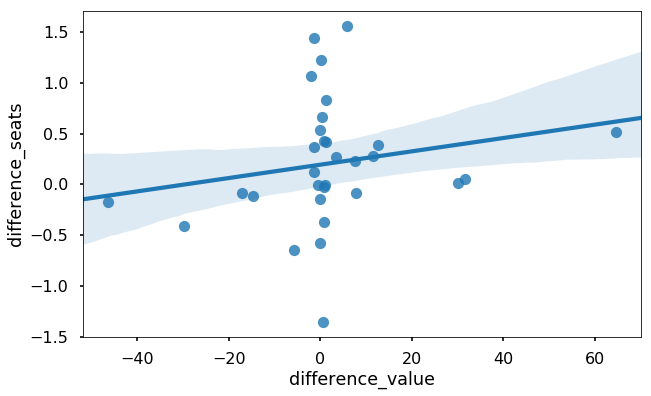

                  difference_value  difference_seats
difference_value          1.000000          0.302419
difference_seats          0.302419          1.000000

Data for 31 countires


In [9]:
elections_indicator, parties = read_eveything("additional_data/economic_indicators/foreign_direct_invesment_out.csv")
plot_everything(elections_indicator, parties, 'difference_value', 'difference_seats')

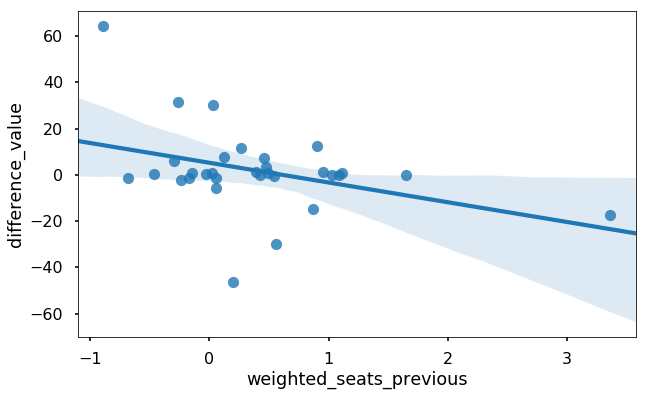

                         weighted_seats_previous  difference_value
weighted_seats_previous                 1.000000         -0.193145
difference_value                       -0.193145          1.000000

Data for 31 countires


In [10]:
plot_everything(elections_indicator, parties, 'weighted_seats_previous', 'difference_value')

### GDP per capita (constant 2010 US$)

We can observe no correlation for this indicator.

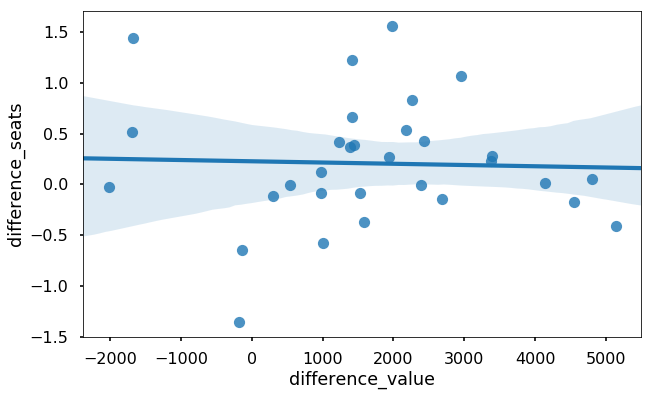

                  difference_value  difference_seats
difference_value          1.000000          0.057258
difference_seats          0.057258          1.000000

Data for 31 countires


In [11]:
elections_indicator, parties = read_eveything("additional_data/economic_indicators/GDP_per_capita.csv")
plot_everything(elections_indicator, parties, 'difference_value', 'difference_seats')

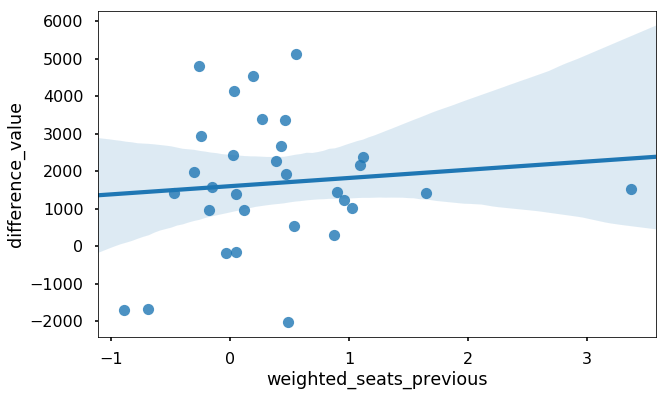

                         weighted_seats_previous  difference_value
weighted_seats_previous                 1.000000          0.070565
difference_value                        0.070565          1.000000

Data for 31 countires


In [12]:
plot_everything(elections_indicator, parties, 'weighted_seats_previous', 'difference_value')

### GDP per capita growth (annual %)

Here, we observe a slight negative correlation in the second plot, indicating that right-leaning policies might cause decline in the growth of GDP. This is something we put in more context in the final data story. 

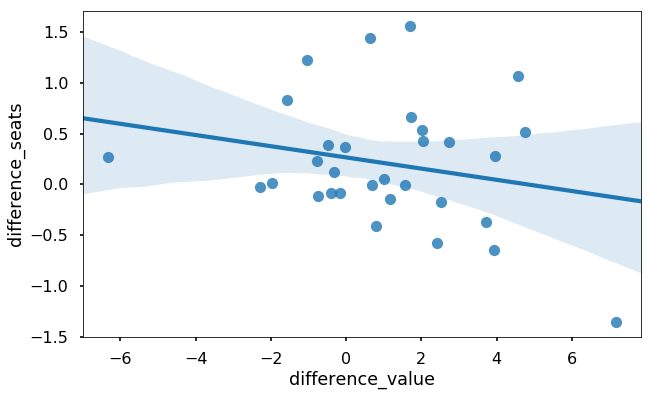

                  difference_value  difference_seats
difference_value          1.000000         -0.117339
difference_seats         -0.117339          1.000000

Data for 31 countires


In [13]:
elections_indicator, parties = read_eveything("additional_data/economic_indicators/GDP_per_capita_growth.csv")
plot_everything(elections_indicator, parties, 'difference_value', 'difference_seats')

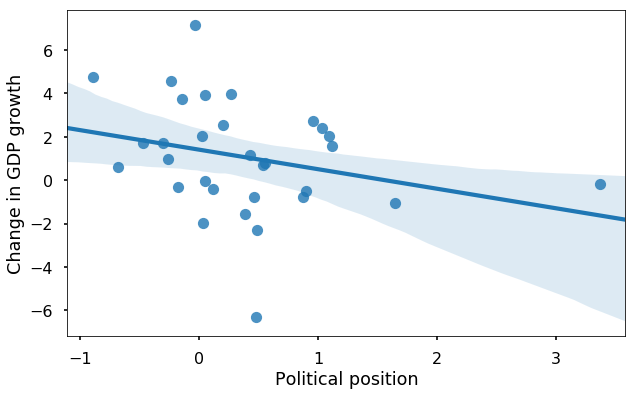

                         weighted_seats_previous  difference_value
weighted_seats_previous                 1.000000         -0.325806
difference_value                       -0.325806          1.000000

Data for 31 countires


In [14]:
params["title"] = ""
params["x_label"] = "Political position"
params["y_label"] = "Change in GDP growth"
params["save_2"] = "gdp_growth.png"
plot_everything(elections_indicator, parties, 'weighted_seats_previous', 'difference_value', params=params)

### Trade (% of GDP)

We can see negative correlation in the second plot indicating that right leaning policies might cause decline in trade because of closed politics.

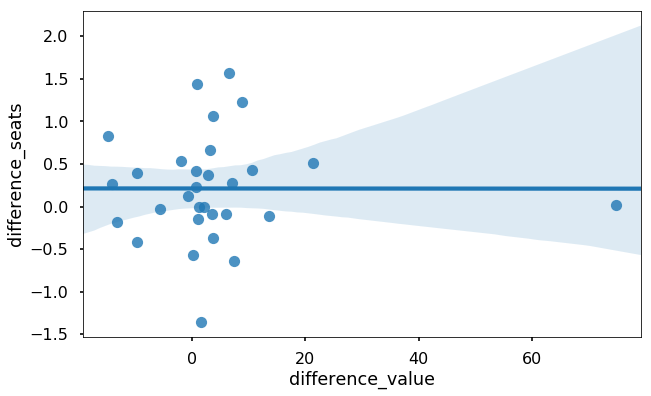

                  difference_value  difference_seats
difference_value           1.00000           0.08921
difference_seats           0.08921           1.00000

Data for 30 countires


In [15]:
elections_indicator, parties = read_eveything("additional_data/economic_indicators/trade.csv")
plot_everything(elections_indicator, parties, 'difference_value', 'difference_seats')

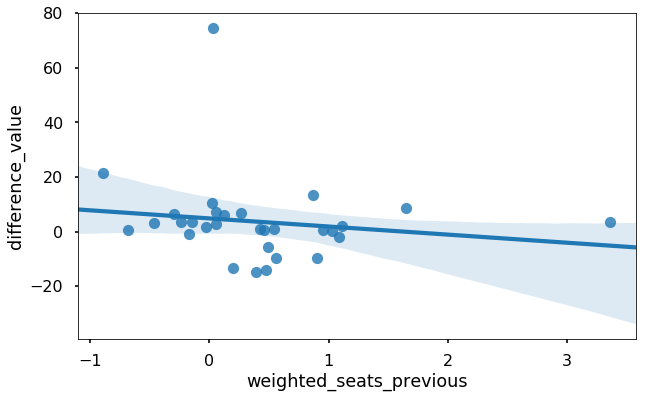

                         weighted_seats_previous  difference_value
weighted_seats_previous                 1.000000         -0.309455
difference_value                       -0.309455          1.000000

Data for 30 countires


In [16]:
plot_everything(elections_indicator, parties, 'weighted_seats_previous', 'difference_value')

### Unemployment, total (% of total labor force) (modeled ILO estimate)

We can see negative correlation in the second plot indicating that right leaning policies might cause decline in unemployment. 

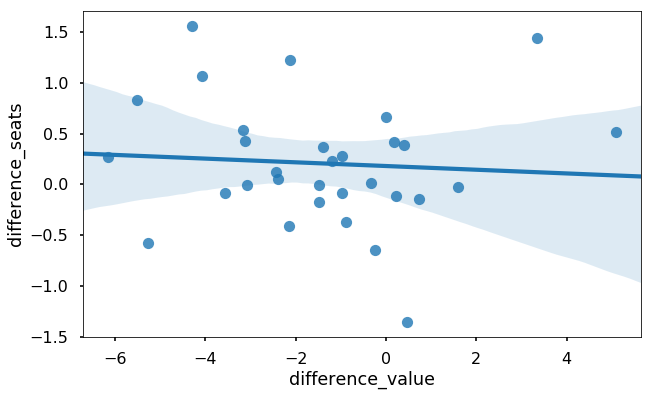

                  difference_value  difference_seats
difference_value          1.000000         -0.168145
difference_seats         -0.168145          1.000000

Data for 31 countires


In [17]:
elections_indicator, parties = read_eveything("additional_data/economic_indicators/unemployment.csv")
plot_everything(elections_indicator, parties, 'difference_value', 'difference_seats')

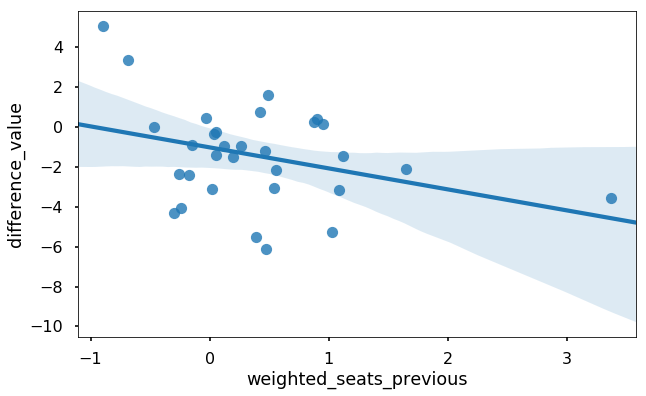

                         weighted_seats_previous  difference_value
weighted_seats_previous                 1.000000         -0.210887
difference_value                       -0.210887          1.000000

Data for 31 countires


In [18]:
plot_everything(elections_indicator, parties, 'weighted_seats_previous', 'difference_value')

# Data for refugees

### Refugee population by country or territory of asylum

https://data.worldbank.org/indicator/SM.POP.REFG

We can see no correlation between the number of refugees in both plots, which is an interesting observation discussed in more detail in the data story. We did not show Germany because it is a big outlier and ruins the visualization, while it has no effect on the slope of the line. We can see that the number of refugees does not cause political shift, and right policies are not more effective in lowering the number of refugees in a country.

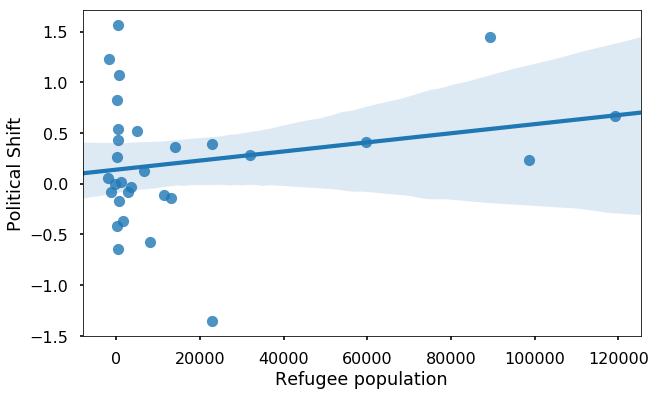

                  difference_value  difference_seats
difference_value          1.000000          0.030927
difference_seats          0.030927          1.000000

Data for 30 countires


In [19]:
elections_indicator, parties = read_eveything("additional_data/refugees/refugee_population.csv")
params["title"] = ""
params["x_label"] = "Refugee population"
params["y_label"] = "Political Shift"
params["save_2"] = "refugee_shift.png"

plot_everything(elections_indicator, parties, 'difference_value', 'difference_seats', hide_germany=True, params=params)

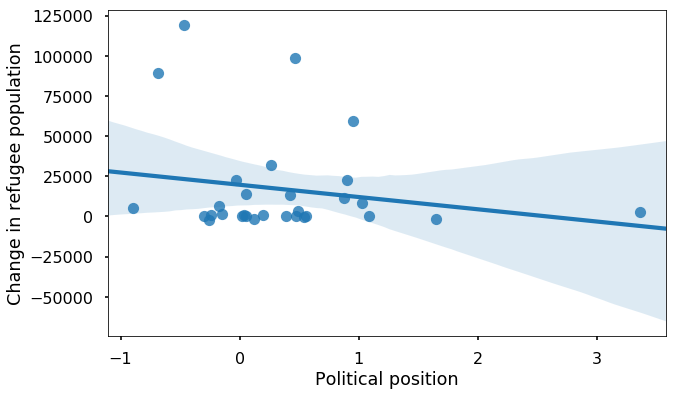

                         weighted_seats_previous  difference_value
weighted_seats_previous                  1.00000          -0.09011
difference_value                        -0.09011           1.00000

Data for 30 countires


In [20]:
params["title"] = ""
params["x_label"] = "Political position"
params["y_label"] = "Change in refugee population"
params["save_2"] = "refugee_position.png"

plot_everything(elections_indicator, parties, 'weighted_seats_previous', 'difference_value', hide_germany=True, params=params)

# Safety

### Military expenditure (% of GDP)
https://data.worldbank.org/indicator/MS.MIL.XPND.GD.ZS

We can see that right leaning countries spend more on military in the second plot. We observe no correlation in the first plot

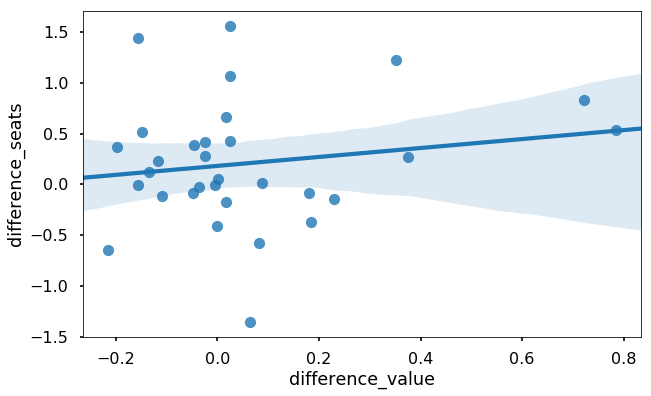

                  difference_value  difference_seats
difference_value          1.000000          0.072984
difference_seats          0.072984          1.000000

Data for 31 countires


In [21]:
elections_indicator, parties = read_eveything("additional_data/safety/military_expenses.csv")


plot_everything(elections_indicator, parties, 'difference_value', 'difference_seats')

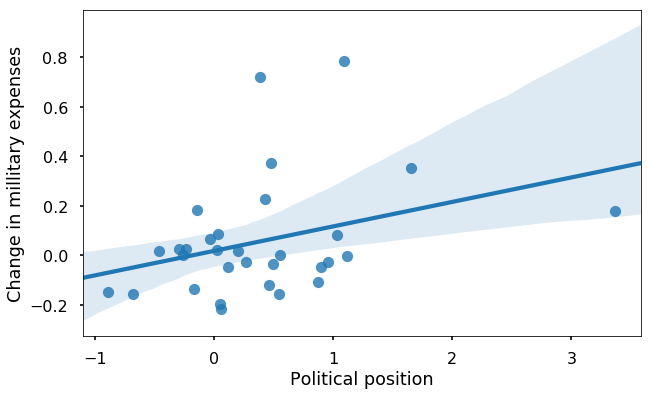

                         weighted_seats_previous  difference_value
weighted_seats_previous                 1.000000          0.237903
difference_value                        0.237903          1.000000

Data for 31 countires


In [22]:
params["title"] = ""
params["x_label"] = "Political position"
params["y_label"] = "Change in millitary expenses"
params["save_2"] = "millitary_position.png"

plot_everything(elections_indicator, parties, 'weighted_seats_previous', 'difference_value', params=params)

### Political Stability and Absence of Violence/Terrorism: Estimate
http://databank.worldbank.org/data/reports.aspx?source=1181&series=PV.EST#

We can see a big correlation in the first plot, which might indicate that the recent terrorist attacks were one of the main cuases of political shift. In the second plot, we see no correlation which means that right leaning parties are not more effective in preventing violence.

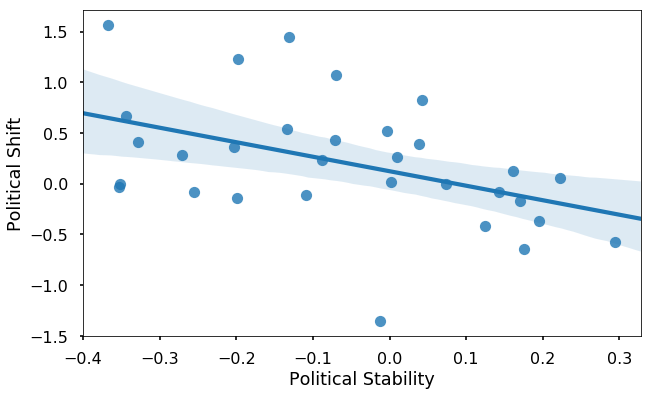

                  difference_value  difference_seats
difference_value              1.00             -0.45
difference_seats             -0.45              1.00

Data for 31 countires


In [23]:
elections_indicator, parties = read_eveything("additional_data/miscellaneous/political_stability.csv", indicator=False)

params["title"] = ""
params["x_label"] = "Political Stability"
params["y_label"] = "Political Shift"
params["save_2"] = "stability_shift.png"

plot_everything(elections_indicator, parties, 'difference_value', 'difference_seats', params=params)

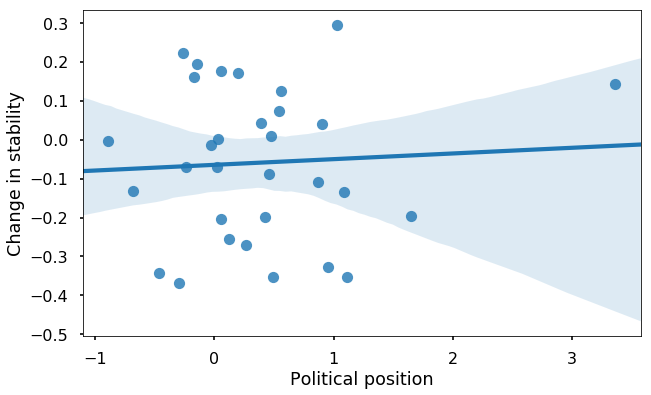

                         weighted_seats_previous  difference_value
weighted_seats_previous                 1.000000         -0.028629
difference_value                       -0.028629          1.000000

Data for 31 countires


In [24]:
params["title"] = ""
params["x_label"] = "Political position"
params["y_label"] = "Change in stability"
params["save_2"] = "stability_position.png"

plot_everything(elections_indicator, parties, 'weighted_seats_previous', 'difference_value', params=params)

# 3. Wikipedia election dataset

In this project, we are interested in the recent rise in popularity of populist countries in EU/EEA. For this purpose, we need a dataset which contains the election results from the previous two elections in each country in order to observe whether there is a change in the popularity or power of right-leaning parties. To the best of our knowledge such dataset does not exist in an explicit form. However, Wikipedia contains pages with the election results for all countries in EU/EEA. An example of such page for the most recent election in Germany can be found <a href="https://en.wikipedia.org/wiki/German_federal_election,_2017">here</a>. Using Wikipedia, we have manually created our dataset of interest. In the following section, we will present the format of the dataset, and some basic statistics. 

In [2]:
# Load and show data
parties = pd.read_csv("wikipedia_datasets/country_party_dataset.csv", index_col=0)
parties.head()

Country ISO2                               Party  Votes_last  Votes %_last  \
0  Austria   AT              Austrian Peoples Party     1595526          31.5   
1  Austria   AT  Social Democratic Party of Austria     1361746          26.9   
2  Austria   AT            Freedom Party of Austria     1316442          26.0   
3  Austria   AT              NEOS – The New Austria      268518           5.3   
4  Austria   AT              Peter Pilz List (PILZ)      223543           4.4   

   Seats_last  Seats %_last  Votes_previous  Votes %_previous  Seats_previous  \
0          62     33.879781         1125876             23.99              47   
1          52     28.415301         1258605             26.82              52   
2          51     27.868852          962313             20.51              40   
3          10      5.464481          232946              4.96               9   
4           8      4.371585               0              0.00               0   

   Seats %_previous        Political_position  
0         25.683060              centre-right  
1         28.415301               centre-left  
2         21.857923   right-wing to far-right  
3          4.918033                    centre  
4          0.000000  centre-left to left-wing

For the purpose of this dataset, we have found the Wikipedia links for the last two elections in each country of EU/EEA. From these pages, we have extracted the results of each election. We are only interested in parties which have won some seats in the national parliament because these parties have some political power and can influence the political situation in a country. We have excluded parties which have not won any seats because they are not relevant to our analysis, and their inclusion would just drastically increase the size of the dataset and decrease its clarity. Some parties have won seats in both of the last elections, but some have won seats in only one of them. We have kept all the parties which won seats in at least one of the elections in the final dataset. We have done this because parties which have won seats in the last elections for example are very relevant in our analysis, even though they have not won any seats previously. In this way, we can analyze the shift in popularity or political power in the countries more effectively. 

Additionally, we have matched each country with its political position. The information for the political position of a party can be found on the Wikipedia page of the party. An example for the German party CDU can be found <a href="https://en.wikipedia.org/wiki/Christian_Democratic_Union_of_Germany">here</a>. The political position (`centre-right` in this case) can be found on the right side under the logo. This information will be very relevant for us in order to observe the shift in popularity of parties with specific political position.

The final dataset contains the following columns:

1. _Country_: The originating country of the party
2. _ISO2_: Abbreviation of the country in ISO 2 format
3. _Party_: Name of the party
4. <i>Votes_last</i>: Votes in the last election
5. <i>Votes %_last</i>: Percentage of votes in last election
6. <i>Seats_last</i>: Seats won in the last election
7. <i>Seats %_last</i>: Percentage of seats won in last election
8. <i>Votes_previous</i>: Votes in the second to last election
9. <i>Votes %_previous</i>: Percentage of votes in second to last election
10. <i>Seats_previous</i>: Seats won in second to last election
11. <i>Seats %_previous</i>: Percentage of seats won in second to last election
12. <i>Political_position</i>: Political position of the party

For the analysis in this section, we augment the data with additional columns containing the group of political positions a party belongs to. This information is not hard coded in the original dataset in order for it to contain only information extracted from Wikipedia.

In [3]:
# Positions sorted in order of political spectrum
positions_sorted = ['far-left', 'left-wing to far-left', 'left-wing', 'centre-left to left-wing', 'centre-left', \
                    'centre to centre-left', 'centre', 'syncretic', 'big tent', 'centre to centre-right', \
                    'centre-right', 'centre-right to right-wing', 'right-wing', 'right-wing to far-right', \
                    'far-right']

For better analysis, we group the political positions in the following groups:

1. `right_wing`: all positions right of `centre`
2. `left_wing`: all positions left of `centre`
3. `far_right`: all positions right of `centre-right to right-wing` 
4. `far_left`: all positions left of `centre-left to left-wing` 
5. `centre`: central positions

After this, we augment the data with the following two columns:

1. _Right or Left_: whether the party is right or left leaning
2. _Far Right or Far Left_: whether the party is in the group `far_left`,  `far_left` or `None` if it is not in any group

In [4]:
right_wing = ['centre-right', 'right-wing to far-right', 'centre-right to right-wing', 'centre to centre-right', 'far-right', 'right-wing']
far_right = ['right-wing to far-right', 'far-right','right-wing']

left_wing = ['left-wing', 'centre-left', 'centre-left to left-wing', 'far-left', 'centre to centre-left', 'left-wing to far-left']
far_left = ['left-wing to far-left', 'far-left', 'left-wing']

center = ['centre', 'big tent', 'syncretic']

In [5]:
# Helper functions
def right_or_left(x):
    if x in right_wing:
        return "Right"
    if x in left_wing:
        return "Left"
    return "Center"

def far_right_or_far_left(x):
    if x in far_right:
        return "Far Right"
    if x in far_left:
        return "Far Left"
    return "None"

In [6]:
# Add additional columns corresponding to group
parties["Right or Left"] = parties["Political_position"].apply(right_or_left)
parties["Far Right or Far Left"] = parties["Political_position"].apply(far_right_or_far_left)

In [7]:
# Show augmented data
parties.head()

Country ISO2                               Party  Votes_last  Votes %_last  \
0  Austria   AT              Austrian Peoples Party     1595526          31.5   
1  Austria   AT  Social Democratic Party of Austria     1361746          26.9   
2  Austria   AT            Freedom Party of Austria     1316442          26.0   
3  Austria   AT              NEOS – The New Austria      268518           5.3   
4  Austria   AT              Peter Pilz List (PILZ)      223543           4.4   

   Seats_last  Seats %_last  Votes_previous  Votes %_previous  Seats_previous  \
0          62     33.879781         1125876             23.99              47   
1          52     28.415301         1258605             26.82              52   
2          51     27.868852          962313             20.51              40   
3          10      5.464481          232946              4.96               9   
4           8      4.371585               0              0.00               0   

   Seats %_previous        Political_position Right or Left  \
0         25.683060              centre-right         Right   
1         28.415301               centre-left          Left   
2         21.857923   right-wing to far-right         Right   
3          4.918033                    centre        Center   
4          0.000000  centre-left to left-wing          Left   

  Far Right or Far Left  
0                  None  
1                  None  
2             Far Right  
3                  None  
4                  None

Let us now show some basic statistics of our dataset.

## Number of parties

First, we will present the number of parties per country.

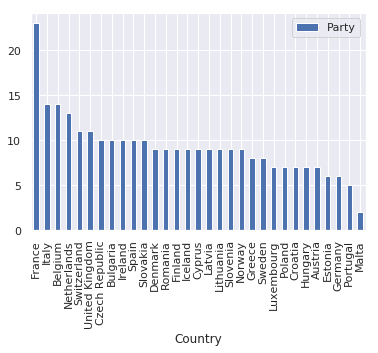

In [8]:
parties_per_country = parties.groupby("Country").count().reset_index()[["Country", "Party"]]
parties_per_country = parties_per_country.sort_values('Party', ascending=False)
parties_per_country.plot(kind="bar", x="Country")

We can observe that France has by far the biggest number of parties and Malta has the smallest number of parties. This two are the biggest outliers. We can see that most countries have around 8-10 parties. However, this information is not very relevant to our analysis because there are a lot cases where parties make coalitions or split between elections. For this reason, we are more interested in the distribution of political positions on the elections, as opposed to concrete parties.

Let us now turn our attention to the distribution of political positions in the EU/EEA parliaments. First, we will take a look at the number of parties per political position in all the countries. 

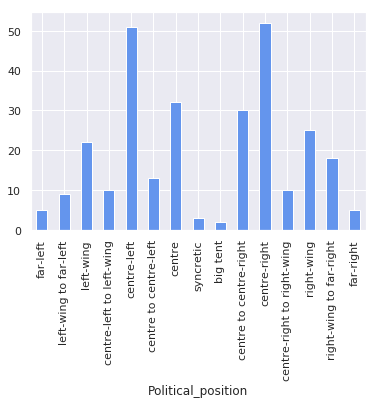

In [9]:
parties_per_position = parties.groupby("Political_position").count().reset_index()
parties_per_position = parties_per_position.set_index("Political_position").reindex(positions_sorted)
parties_per_position.plot(kind="bar", y="Party", color='cornflowerblue', legend=False)

We can see that most represented political positions are `centre-left` and `centre-right`. This shows that most of the parties in Europe are centristic with a right or left lean. However, we are alo interested whether there are more parties on the right or left political spectrum. For this purpose, we can use the additional columns created above. Let us now plot the distribution of the column `Right or Left` in order to answer this question. 

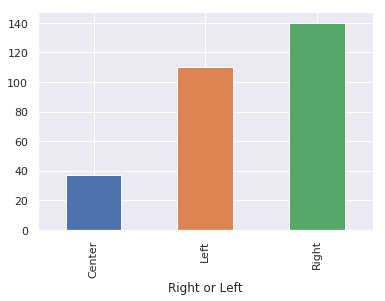

In [10]:
parties_per_position = parties.groupby("Right or Left").count().reset_index()
parties_per_position.plot(kind="bar", x="Right or Left", y="Party", legend=False)

From the plot, we can conclude that there are indeed more right-leaning parties that left-leaning ones. This is a first indicator that the parliaments of EU/EAA countries contain more conservative than liberal parties. However, this point needs to be investigated further for valid conclusions. Apart from left and right lean, we are interested whether there are more far right than far left parties. For this purpose we will investigate the distribution of the feature `Far Right or Far Left` created earlier. 

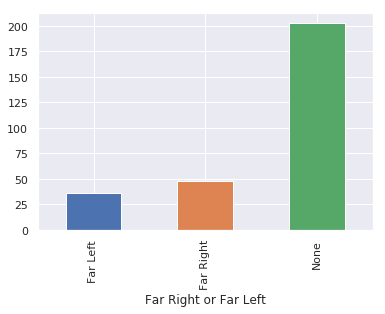

In [11]:
parties_per_position = parties.groupby("Far Right or Far Left").count().reset_index()
parties_per_position.plot(kind="bar", x="Far Right or Far Left", y="Party", legend=False)

As expected most of the parties do not belong to either of the groups. However, we again observe more far right parties than far left. This is an interesting phenomena which will present the basis for our analysis in the following milestone. 

In this project, we are interested in the recent rise in popularity of populist countries in EU/EEA. For this purpose, we need a dataset which contains the election results from the previous two elections in each country in order to observe whether there is a change in the popularity or power of right-leaning parties. To the best of our knowledge such dataset does not exist in an explicit form. However, Wikipedia contains pages with the election results for all countries in EU/EEA. An example of such page for the most recent election in Germany can be found <a href="https://en.wikipedia.org/wiki/German_federal_election,_2017">here</a>. Using Wikipedia, we have manually created our dataset of interest. In the following section, we will present the format of the dataset, and some basic statistics. 

## Number of votes - indicator for popularity

We want to investigate the number of votes gained by parties from each political position as a sign of the popularity of the position. Additionally, we will observe the difference in votes between the two election in order to observe the change in popularity in the most recent elections. We are currently taking a look at the number of votes because we want to investigate the global popularity of the positions in Europe. We plan to also investigate the average popularity by repeating the same analysis with the percentage of votes, but this analysis is excluded from this notebook because it will only be a repetiton of code. 

In [8]:
votes_per_position = parties.groupby("Political_position").sum().reset_index()
votes_per_position = votes_per_position.set_index("Political_position").reindex(positions_sorted)

In [9]:
# This is the color palette that we use in our plots
sns.set()
current_palette = sns.color_palette()

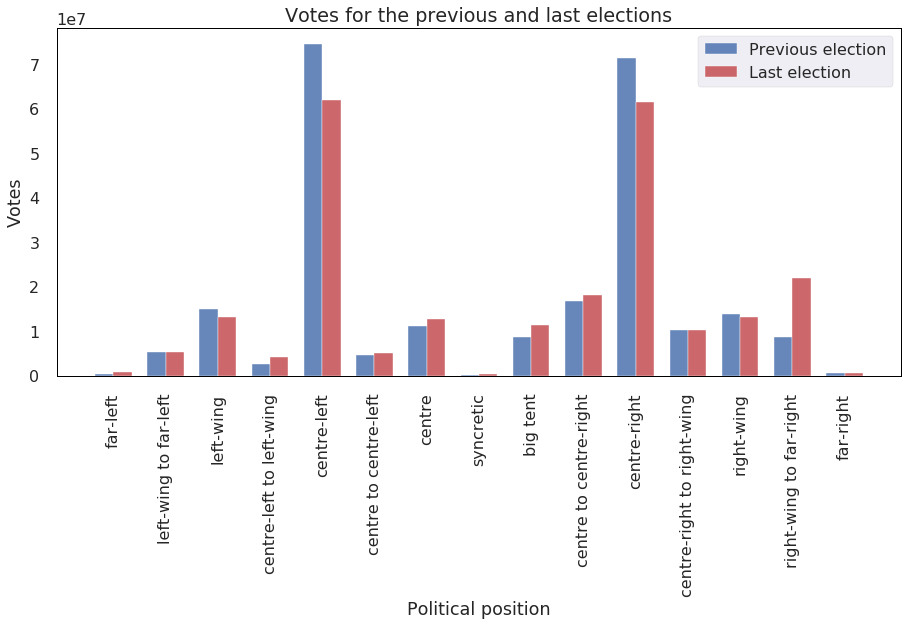

In [10]:
# create plot
plt.style.use('seaborn-poster')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
fig, ax = plt.subplots()
ax.set_facecolor("white")
index = np.arange(votes_per_position.shape[0])
bar_width = 0.35
opacity = 0.85
 
rects1 = plt.bar(index, votes_per_position["Votes_previous"], bar_width,
                 alpha=opacity,
                 color=current_palette[0],
                 label='Previous election')
 
rects2 = plt.bar(index + bar_width, votes_per_position["Votes_last"], bar_width,
                 alpha=opacity,
                 color=current_palette[3],
                 label='Last election')
 
plt.xlabel('Political position')
plt.ylabel('Votes')
plt.title('Votes for the previous and last elections')
plt.xticks(index + bar_width/2, list(votes_per_position.index))
plt.legend()

for item in ax.axes.get_xticklabels():
    item.set_rotation(90)
    
plt.tight_layout()
plt.show()
fig.savefig("votes_positions.png", bbox_inches="tight", dpi=200)

This plot shows us some very interesting phenomena. For example, even though center-right and center-left parties remain most popular in the last elections, their popularity has dramatically decreased in the last elections. On the other hand, there is a dramatic increase in the popularity of the right-wing to far-right parties. This is yet another indicator that the popularity of nationalist parties is increasing in the recent years. 

Same as before, we are also interested in the number of votes for right, left and central leaning parties. We present the number of votes for each group in the following plot.

In [11]:
votes_per_position = parties.groupby("Right or Left").sum().reset_index()

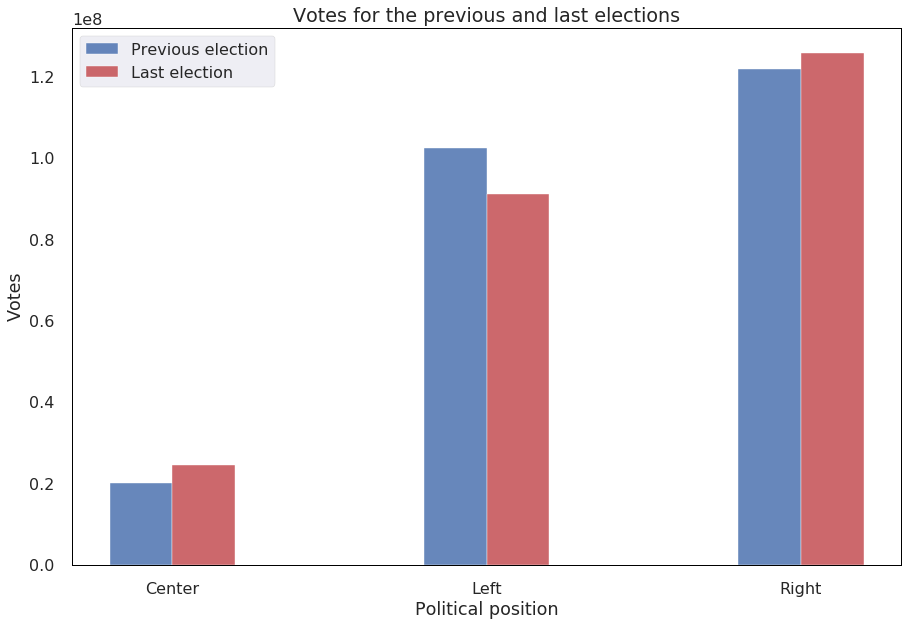

In [12]:
# create plot
plt.style.use('seaborn-poster')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
fig, ax = plt.subplots()
ax.set_facecolor("white")
index = np.arange(votes_per_position.shape[0])
bar_width = 0.20
opacity = 0.85
 
rects1 = plt.bar(index, votes_per_position["Votes_previous"], bar_width,
                 alpha=opacity,
                 color=current_palette[0],
                 label='Previous election')
 
rects2 = plt.bar(index + bar_width, votes_per_position["Votes_last"], bar_width,
                 alpha=opacity,
                 color=current_palette[3],
                 label='Last election')
 
plt.xlabel('Political position')
plt.ylabel('Votes')
plt.title('Votes for the previous and last elections')
plt.xticks(index + bar_width/2, list(votes_per_position["Right or Left"]))
plt.legend()
    
plt.tight_layout()
plt.show()
fig.savefig("votes_positions_aggregated.png", bbox_inches="tight", dpi=200)

Yet again, we observe that right leaning parties are most popular in Europe, even when we consider the number of votes as opposed to number of parties. The plot also confirms our hypothesis that right-leaning parties are gaining popularity in the most recent elections. Central parties have also gained popularity. On the other hand, left-leaning parties have lost popularity. This indicats that the political spectrum of Europe is shifting to the right.

Let us now repeat the same analysis with regards to the far-right and far-left groups. 

In [13]:
votes_per_position = parties.groupby("Far Right or Far Left").sum().reset_index()

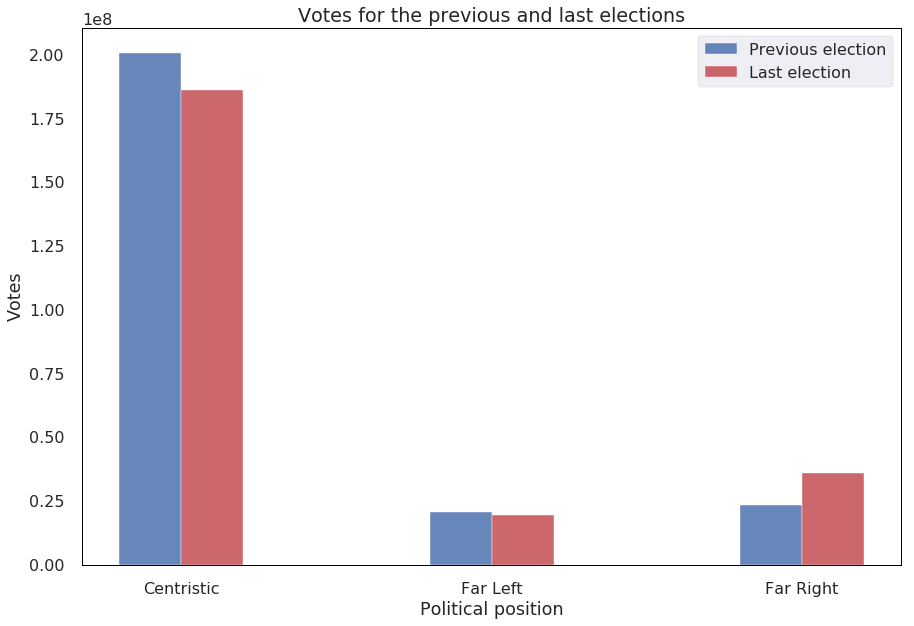

In [14]:
# create plot
plt.style.use('seaborn-poster')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
fig, ax = plt.subplots()
ax.set_facecolor("white")
index = np.arange(votes_per_position.shape[0])
bar_width = 0.20
opacity = 0.85
 
rects1 = plt.bar(index, votes_per_position["Votes_previous"], bar_width,
                 alpha=opacity,
                 color=current_palette[0],
                 label='Previous election')
 
rects2 = plt.bar(index + bar_width, votes_per_position["Votes_last"], bar_width,
                 alpha=opacity,
                 color=current_palette[3],
                 label='Last election')
 
plt.xlabel('Political position')
plt.ylabel('Votes')
plt.title('Votes for the previous and last elections')
plt.xticks(index + bar_width/2, list(votes_per_position["Far Right or Far Left"]))
plt.legend()
    
plt.tight_layout()
plt.show()
fig.savefig("votes_positions_aggregated_far.png", bbox_inches="tight", dpi=200)

Once again, we observe the same phenomenon - far right parties are gaining popularity, and far left ones are losing their popularity. Additionally, the parties in between are also losing popularity. We can safely conclude that **the Right is gaining popularity**.

## Number of seats - indicator for political power

In the previous section, we have seen that the right leaning parties are gaining popularity. However, this does not mean that the right leaning parties are gaining political power. In order to investigate whether this is the case, we need to look at the percentage of seats won by parties from each political position. In this case, it makes much more sense to use the percentage of seats won as opposed to the total number because each country has a different number of seats in the parliament. We do not want to give more weight to countries with bigger parliaments. 

Let us start with comparing all the political positions.

In [15]:
# get all political positions, 15 in total
poltical_positions = np.unique(parties["Political_position"])
seats_per_position_total = parties.groupby(["Country", "Political_position"]).sum().reset_index()
# get all countries, 15 in total
countires = np.unique(seats_per_position_total["Country"])

In [16]:
for c in countires:
    # for a given country, find the political positions the country doesn't have
    pos = seats_per_position_total[seats_per_position_total["Country"] == c]["Political_position"]
    not_in_c = [x for x in poltical_positions if x not in list(pos)]
    
    for p in not_in_c:
        # for the missing positions, add new row with all values as zero
        row = np.array([c, p, 0, 0, 0, 0, 0, 0, 0, 0])
        seats_per_position_total.loc[-1] = row  # adding a row
        seats_per_position_total.index = seats_per_position_total.index + 1  # shifting index
        seats_per_position_total = seats_per_position_total.sort_index()  # sorting by index
        
for c in seats_per_position_total.columns[2:]:
    seats_per_position_total[c] = seats_per_position_total[c].astype(float)

In [17]:
seats_per_position_final = seats_per_position_total.groupby("Political_position").mean().reset_index()
seats_per_position_final = seats_per_position_final.set_index("Political_position").reindex(positions_sorted)

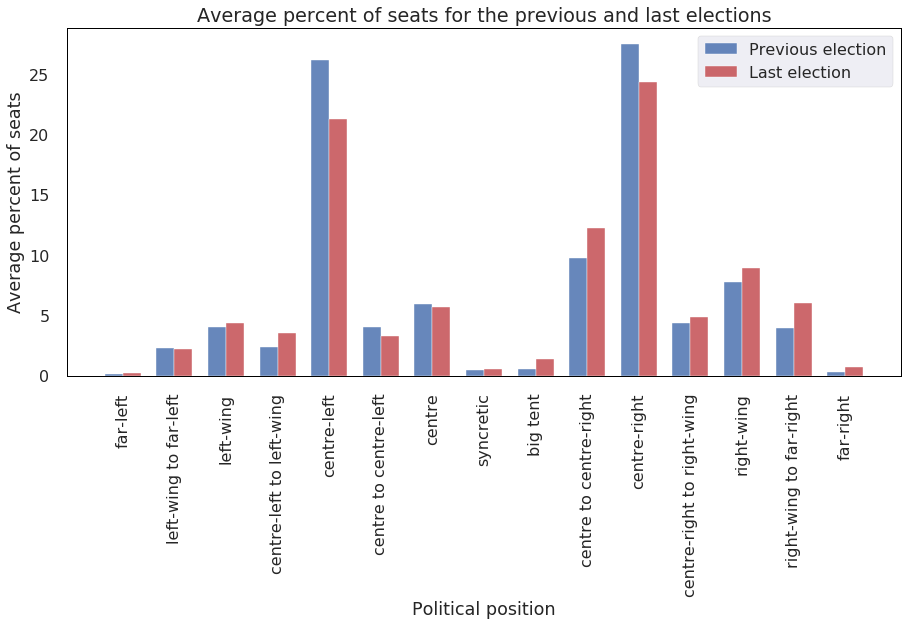

In [18]:
# create plot
plt.style.use('seaborn-poster')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
fig, ax = plt.subplots()
ax.set_facecolor("white")
index = np.arange(seats_per_position_final.shape[0])
bar_width = 0.35
opacity = 0.85
 
rects1 = plt.bar(index, seats_per_position_final["Seats %_previous"], bar_width,
                 alpha=opacity,
                 color=current_palette[0],
                 label='Previous election')
 
rects2 = plt.bar(index + bar_width, seats_per_position_final["Seats %_last"], bar_width,
                 alpha=opacity,
                 color=current_palette[3],
                 label='Last election')
 
plt.xlabel('Political position')
plt.ylabel('Average percent of seats')
plt.title('Average percent of seats for the previous and last elections')
plt.xticks(index + bar_width/2, list(seats_per_position_final.index))
plt.legend()

for item in ax.axes.get_xticklabels():
    item.set_rotation(90)
    
plt.tight_layout()
plt.show()
fig.savefig("seats_positions.png", bbox_inches="tight", dpi=200)

In the case of seats, the rise of the right is even more noticeable. First of all, we observe that centre-right and centre-left are again most powerful positions, but their power has decreased in the last elections. However, centre-right parties remain more powerful than centre-left ones. Another interesting phenomena is the fact that all positions on the right have gained seats except centre-right parties. On the other hand, several positions on the left have lost percentage of seats. 

Let us now repeat the analysis using the split on right, left and center leaning parties.

In [19]:
# get all political positions, 15 in total
poltical_positions = np.unique(parties["Right or Left"])
seats_per_position_total = parties.groupby(["Country", "Right or Left"]).sum().reset_index()
# get all countries, 15 in total
countires = np.unique(seats_per_position_total["Country"])

In [20]:
for c in countires:
    # for a given country, find the political positions the country doesn't have
    pos = seats_per_position_total[seats_per_position_total["Country"] == c]["Right or Left"]
    not_in_c = [x for x in poltical_positions if x not in list(pos)]
    
    for p in not_in_c:
        # for the missing positions, add new row with all values as zero
        row = np.array([c, p, 0, 0, 0, 0, 0, 0, 0, 0])
        seats_per_position_total.loc[-1] = row  # adding a row
        seats_per_position_total.index = seats_per_position_total.index + 1  # shifting index
        seats_per_position_total = seats_per_position_total.sort_index()  # sorting by index
        
for c in seats_per_position_total.columns[2:]:
    seats_per_position_total[c] = seats_per_position_total[c].astype(float)

In [21]:
seats_per_position_final = seats_per_position_total.groupby("Right or Left").mean().reset_index()

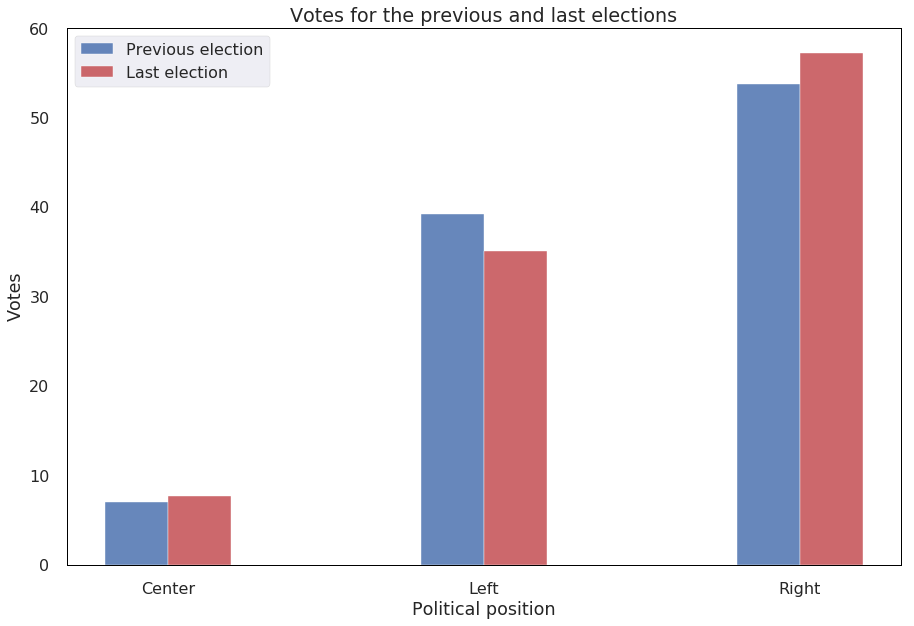

In [22]:
# create plot
plt.style.use('seaborn-poster')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
fig, ax = plt.subplots()
ax.set_facecolor("white")
index = np.arange(seats_per_position_final.shape[0])
bar_width = 0.20
opacity = 0.85
 
rects1 = plt.bar(index, seats_per_position_final["Seats %_previous"], bar_width,
                 alpha=opacity,
                 color=current_palette[0],
                 label='Previous election')
 
rects2 = plt.bar(index + bar_width, seats_per_position_final["Seats %_last"], bar_width,
                 alpha=opacity,
                 color=current_palette[3],
                 label='Last election')
 
plt.xlabel('Political position')
plt.ylabel('Votes')
plt.title('Votes for the previous and last elections')
plt.xticks(index + bar_width/2, list(seats_per_position_final["Right or Left"]))
plt.legend()
    
plt.tight_layout()
plt.show()
fig.savefig("seats_positions_aggregated.png", bbox_inches="tight", dpi=200)

Once again, we observe the same evolution as in the number of votes. The political power is shifting to the right. 

Finally, let's observe the performance of far left and far right parties.

In [23]:
# get all political positions, 15 in total
poltical_positions = np.unique(parties["Far Right or Far Left"])
seats_per_position_total = parties.groupby(["Country", "Far Right or Far Left"]).sum().reset_index()
# get all countries, 15 in total
countires = np.unique(seats_per_position_total["Country"])

In [24]:
for c in countires:
    # for a given country, find the political positions the country doesn't have
    pos = seats_per_position_total[seats_per_position_total["Country"] == c]["Far Right or Far Left"]
    not_in_c = [x for x in poltical_positions if x not in list(pos)]
    
    for p in not_in_c:
        # for the missing positions, add new row with all values as zero
        row = np.array([c, p, 0, 0, 0, 0, 0, 0, 0, 0])
        seats_per_position_total.loc[-1] = row  # adding a row
        seats_per_position_total.index = seats_per_position_total.index + 1  # shifting index
        seats_per_position_total = seats_per_position_total.sort_index()  # sorting by index
        
for c in seats_per_position_total.columns[2:]:
    seats_per_position_total[c] = seats_per_position_total[c].astype(float)

In [25]:
seats_per_position_final = seats_per_position_total.groupby("Far Right or Far Left").mean().reset_index()

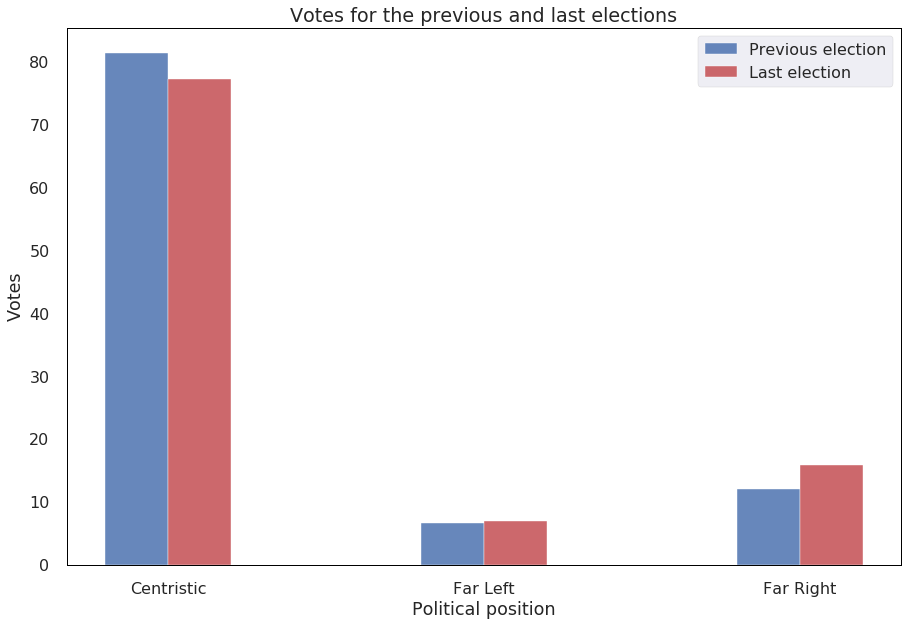

In [26]:
# create plot
plt.style.use('seaborn-poster')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
fig, ax = plt.subplots()
ax.set_facecolor("white")
index = np.arange(seats_per_position_final.shape[0])
bar_width = 0.20
opacity = 0.85
 
rects1 = plt.bar(index, seats_per_position_final["Seats %_previous"], bar_width,
                 alpha=opacity,
                 color=current_palette[0],
                 label='Previous election')
 
rects2 = plt.bar(index + bar_width, seats_per_position_final["Seats %_last"], bar_width,
                 alpha=opacity,
                 color=current_palette[3],
                 label='Last election')
 
plt.xlabel('Political position')
plt.ylabel('Votes')
plt.title('Votes for the previous and last elections')
plt.xticks(index + bar_width/2, list(seats_per_position_final["Far Right or Far Left"]))
plt.legend()
    
plt.tight_layout()
plt.show()
fig.savefig("seats_positions_aggregated_far.png", bbox_inches="tight", dpi=200)

The plot indicates that far right parties are gaining power. However, in this case the far left parties have also gained some power. This is an interesting phenomena which is not in compliance with our hypothesis. We plan to investigate further the causes and interpretation of this observation in the next milestone. One implication of this plot is that the parliaments of EU/EEA are becoming more polarized. The causes and effects of this polarization will be a major focus of our final data story. Nevertheless, the gain in popularity is much bigger in the far right parties, so we can conclude that **the Right is gaining power**.

# Weighted political position of the countries

For our analysis we needed to represent the position of each country's Parliament with a numerical value. We achiece this by first assigning a numerical value between -6 and 6 to each political position as shown below.

In [4]:
parties = pd.read_csv("data/country_party_dataset.csv", index_col=0)
positions = pd.read_csv("data/positions_scale.csv")
positions

Position  Scale
0                     far-left     -6
1        left-wing to far-left     -5
2                    left-wing     -4
3     centre-left to left-wing     -3
4                  centre-left     -2
5        centre to centre-left     -1
6                       centre      0
7                    syncretic      0
8                     big tent      0
9       centre to centre-right      1
10                centre-right      2
11  centre-right to right-wing      3
12                  right-wing      4
13     right-wing to far-right      5
14                   far-right      6

We found that linear scale work best and is the more intuitive choice. All the centristic position are assigned a value of 0 and do not contribute to the shift in the political position of a country.

In [5]:
positions_sorted = ['far-left', 'left-wing to far-left', 'left-wing', 'centre-left to left-wing', 'centre-left', \
                    'centre to centre-left', 'centre', 'syncretic', 'big tent', 'centre to centre-right', \
                    'centre-right', 'centre-right to right-wing', 'right-wing', 'right-wing to far-right', \
                    'far-right']

In order to obtain a numerical value for the position of the Parliament, we multiply the value of the political position of a country by the percentage of seats won in the election. Then, we sum this values for all the parties in the country's parliament to obtain one numerical value for each parliament. In this way, a parliament with 100% of far-right party members would have a value fo 6, and a parliament with 100% of far-left part members would have a value of -6. In reality, the values of all countries are somewhere in betweeen. Positive values represent right-leaning countries, and negative values represent left-leaning countries. The absolute value of the political position represents the magnitude of the lean.

In [6]:
parties = pd.merge(parties, positions, left_on=["Political_position"], right_on=["Position"])

In [7]:
parties["weighted_seats_last"] = (parties["Seats %_last"]/100)*parties["Scale"]
parties["weighted_seats_previous"] = (parties["Seats %_previous"]/100)*parties["Scale"]

In [8]:
parties["weighted_votes_last"] = (parties["Votes %_last"]/100)*parties["Scale"]
parties["weighted_votes_previous"] = (parties["Votes %_previous"]/100)*parties["Scale"]

In [9]:
parties = parties.groupby("Country").sum()

We are also interested in the shift in the position of the Parliamentbetween the two election which is calculated as the difference in the position between the second and first election. 

In [10]:
parties["difference_seats"] = parties["weighted_seats_last"] - parties["weighted_seats_previous"]
parties["difference_votes"] = parties["weighted_votes_last"] - parties["weighted_votes_previous"]

In [11]:
parties = parties.reset_index()

In the following plot, we represent the average position of the Parliament after the last election. The red color is used to represent left-leaning countries because of the tradional use of this color by socialist groups and parties. The blue color is chosen to represent the conservative countries as a tradional color of the right. We use this color scheme for representing countries throughout the notebook and the data story. 

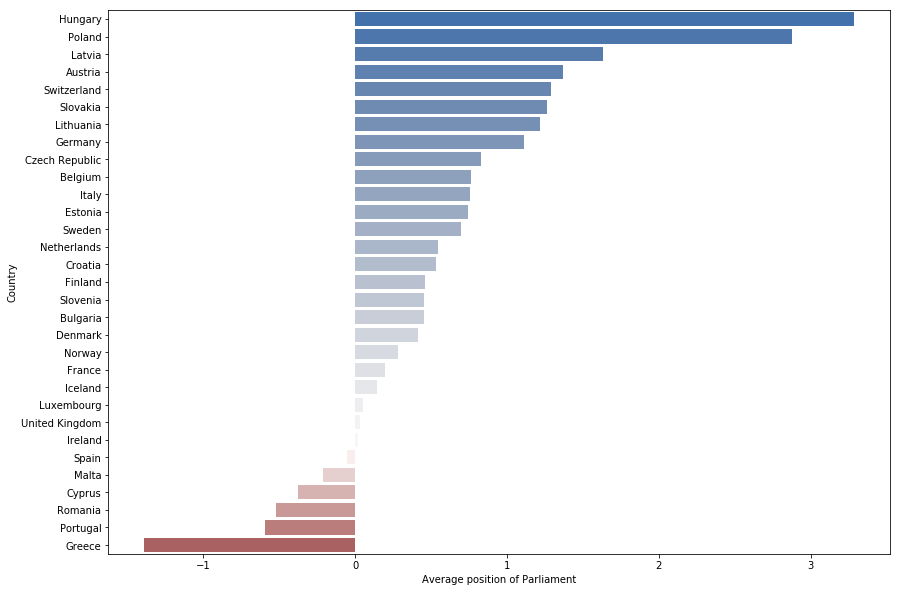

In [12]:
column = 'weighted_seats_last'
sorted_difference = parties.sort_values(column, ascending=False).reset_index()

left_count = sorted_difference[sorted_difference[column] < 0].shape[0]
right_count = sorted_difference[sorted_difference[column] > 0].shape[0]

red_palette = sns.color_palette("vlag", left_count*2)[left_count:]
blue_palette = sns.color_palette("vlag", right_count*2)[:right_count]
#blue_palette.reverse()
palette =  blue_palette + red_palette

a4_dims = (14, 10)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.barplot(ax=ax, x=column, y ="Country", data=sorted_difference, palette=palette)
g.set(xlabel='Average position of Parliament')
fig = g.get_figure()
fig.savefig(column+".png", bbox_inches='tight')

We present the same data on a Folium map to look for some spatial correlation. We can see that eastern countries are more conservative, and Mediteranian countries are most left-leaning.

In [13]:
countries = sorted_difference['Country'].values.tolist()

In [16]:
# Read the Geo JSON file
EU_geo_path = "data/europe.geojson"
geo_json_data = json.load(open(EU_geo_path))

In [17]:
import folium
import branca.colormap as cm

colorscale = cm.LinearColormap(colors=['blue','ghostwhite','red'], vmin=0, vmax=12)

# Function for coloring the countires
def style_function(feature):
    idx = countries.index(feature)
    temp = tuple([int(255*x) for x in palette[idx]])
    color = '#%02x%02x%02x' % temp
    return color
    pol_pos = votes_grouped[votes_grouped["Country"] == feature]["Political_position"].values[0]
    if pol_pos == 'syncretic' or pol_pos == 'big tent':
        pol_pos = "centre"
    pos = position_sorted.index(pol_pos)
    return colorscale(pos)

# Create map
m = folium.Map(
    location=[54, 12],
    tiles='cartodbpositron',
    zoom_start=4
)

# Add Geo JSON data to the map with custom colors
folium.GeoJson(geo_json_data,
    name='geojson',
    style_function=lambda feature: {
        'fillOpacity': 0.9,
        'fillColor': style_function(feature['properties']['NAME']),
        'color' : 'black',
        'weight' : 1
        }
    ).add_to(m)

m.save(column + '.html')
m

Next, we show the shift in political position between the two elections.

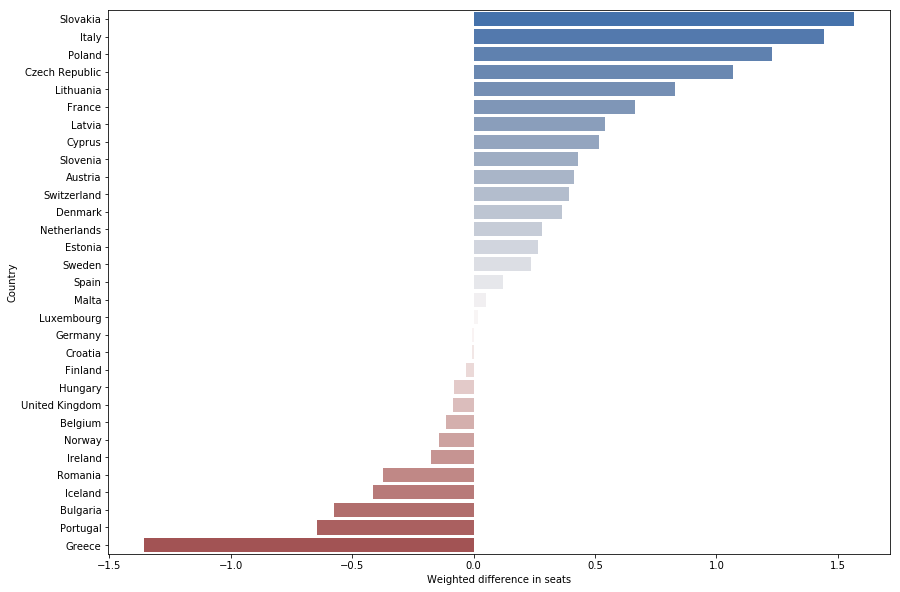

In [18]:
column = 'difference_seats'
sorted_difference = parties.sort_values(column, ascending=False).reset_index()

left_count = sorted_difference[sorted_difference[column] < 0].shape[0]
right_count = sorted_difference[sorted_difference[column] > 0].shape[0]

red_palette = sns.color_palette("vlag", left_count*2)[left_count:]
blue_palette = sns.color_palette("vlag", right_count*2)[:right_count]
#blue_palette.reverse()
palette =  blue_palette + red_palette

a4_dims = (14, 10)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.barplot(ax=ax, x=column, y ="Country", data=sorted_difference, palette=palette)
g.set(xlabel='Weighted difference in seats')
fig = g.get_figure()
fig.savefig(column+".png", bbox_inches='tight')

Once again, we draw the data on a map to look for some spatial relationship.

In [19]:
countries = sorted_difference['Country'].values.tolist()

In [20]:
import folium
import branca.colormap as cm

colorscale = cm.LinearColormap(colors=['blue','ghostwhite','red'], vmin=0, vmax=12)

# Function for coloring the countires
def style_function(feature):
    idx = countries.index(feature)
    temp = tuple([int(255*x) for x in palette[idx]])
    color = '#%02x%02x%02x' % temp
    return color
    pol_pos = votes_grouped[votes_grouped["Country"] == feature]["Political_position"].values[0]
    if pol_pos == 'syncretic' or pol_pos == 'big tent':
        pol_pos = "centre"
    pos = position_sorted.index(pol_pos)
    return colorscale(pos)

# Create map
m = folium.Map(
    location=[54, 12],
    tiles='cartodbpositron',
    zoom_start=4
)

# Add Geo JSON data to the map with custom colors
folium.GeoJson(geo_json_data,
    name='geojson',
    style_function=lambda feature: {
        'fillOpacity': 0.9,
        'fillColor': style_function(feature['properties']['NAME']),
        'color' : 'black',
        'weight' : 1
        }
    ).add_to(m)

m.save(column + '.html')
m

Once again, we see that Eastern European countries have shifted to the right, while countries in Southern and Northern Europe have shifted to the left. We can conclude that the geopolitical position of a country might be an indicator of the election results. We discuss these findings in more detail and context in the data story. 